# EV Battery Health Prediction
Intelligent Predictive Maintenance and Battery Health Forecasting System for Electric Vehicles. 

***The project focuses on predicting **State of Health (SoH)** and **Remaining Useful Life (RUL)** of lithium-ion batteries usingmachine learning techniques across supervised, unsupervised, and reinforcement learning paradigms.***

**Primary Goals**
-   Predict battery SoH within ±5% absolute error on unseen data
-   Estimate RUL with >90% recall for failure detection
-   Build a scalable, deployable ML pipeline
-   Deploy as a web application on free hosting platforms

**Technical Requirements**
-   Implement supervised learning (Random Forest, XGBoost, LSTM/GRU)
-   Apply unsupervised learning (K-means clustering for degradation patterns)
-   Integrate reinforcement learning (Q-learning for charging optimization)
-   Achieve engineering-grade data quality (<5% missing data)

Problem Statement

*   **Objective:** To develop an Intelligent Predictive Maintenance System that estimates the **State of Health (SoH)** and forecasts the **Remaining Useful Life (RUL)** of Lithium-ion batteries.
*   **Goal:** The primary technical goals were to predict battery SoH with less than ±5% absolute error and to build a foundation for RUL forecasting with high recall for failure detection.
*   **Dataset:** The project utilizes the NASA Prognostics Center of Excellence (PCoE) dataset, which contains detailed charge, discharge, and impedance data from aging Li-ion batteries in raw MATLAB (`.mat`) format.
*   **Challenge:** The core challenges involved parsing the complex, nested `.mat` files, engineering meaningful features from the raw sensor data, and applying a range of machine learning models to accurately capture the non-linear degradation patterns of the batteries.

In [102]:
from IPython.display import Markdown

def print_df(df):
    """
    Forces the dataframe to render as a Markdown table.
    This enables Word to apply Borders and Fonts from your reference doc.
    """
    # to_markdown requires the 'tabulate' package: pip install tabulate
    display(Markdown(df.to_markdown(index=False)))

In [103]:
import sys
import pandas as pd
import numpy as np
from scipy.io import whosmat
from scipy.io import loadmat
from io import BytesIO
import datetime
import tensorflow as tf
import random
import os

print(sys.executable)


g:\DIYguru\Data-Science-and-Engineering-Analytics\.venv\Scripts\python.exe


In [ ]:
# Set random seeds for reproducibility
'''
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print("Random seeds set for reproducibility.")
'''

# Dataset Acquisition

**NASA PCoE Battery Dataset**
-   Location: https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/
-   Download: Dataset 5: Batteries - Experiments on Li-Ion batteries with charging and discharging at different temperatures, recording impedance       spectroscopy measurements. https://phm-datasets.s3.amazonaws.com/NASA/5.+Battery+Data+Set.zip
-   Contains: Li-ion 18650 battery aging data
-   Batteries: B0005, B0006, B0007, B0018 (commonly used for testing)
-   Format: .mat files with voltage, current, temperature, capacity

In [104]:
print(whosmat(r'G:\DIYguru\Data-Science-and-Engineering-Analytics\Capstone_Project\source_data\B0005.mat'))
print(whosmat(r'G:\DIYguru\Data-Science-and-Engineering-Analytics\Capstone_Project\source_data\B0006.mat'))
print(whosmat(r'G:\DIYguru\Data-Science-and-Engineering-Analytics\Capstone_Project\source_data\B0007.mat'))
print(whosmat(r'G:\DIYguru\Data-Science-and-Engineering-Analytics\Capstone_Project\source_data\B0018.mat'))

[('B0005', (1, 1), 'struct')]
[('B0006', (1, 1), 'struct')]
[('B0007', (1, 1), 'struct')]
[('B0018', (1, 1), 'struct')]


In [105]:
file_path_B0005 = r'G:\DIYguru\Data-Science-and-Engineering-Analytics\Capstone_Project\source_data\B0005.mat'
file_path_B0006 = r'G:\DIYguru\Data-Science-and-Engineering-Analytics\Capstone_Project\source_data\B0006.mat'
file_path_B0007 = r'G:\DIYguru\Data-Science-and-Engineering-Analytics\Capstone_Project\source_data\B0007.mat'
file_path_B0018 = r'G:\DIYguru\Data-Science-and-Engineering-Analytics\Capstone_Project\source_data\B0018.mat'

data_B0005 = loadmat(file_path_B0005, struct_as_record=False, squeeze_me=True)
data_B0006 = loadmat(file_path_B0006, struct_as_record=False, squeeze_me=True)
data_B0007 = loadmat(file_path_B0007, struct_as_record=False, squeeze_me=True)
data_B0018 = loadmat(file_path_B0018, struct_as_record=False, squeeze_me=True)

# Access the struct
b0005 = data_B0005['B0005']
b0006 = data_B0006['B0006']
b0007 = data_B0007['B0007']
b0018 = data_B0018['B0018']

# Check what attributes (fields) this struct has
print('b0005 \n',dir(b0005))
print('b0006 \n',dir(b0006))
print('b0007 \n',dir(b0007))
print('b0018 \n',dir(b0018))

b0005 
 ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_fieldnames', 'cycle']
b0006 
 ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_fieldnames', 'cycle']
b0007 
 ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__'

In [ ]:
print(b0005.cycle)
print(b0006.cycle)
print(b0007.cycle)
print(b0018.cycle)

In [107]:
cycles = b0005.cycle
#cycles = b0006.cycle
#cycles = b0007.cycle
#cycles = b0018.cycle

print(type(cycles))

<class 'numpy.ndarray'>


In [108]:
print(len(cycles),"\n")

print(cycles[0],"\n")
print([col for col in dir(cycles[0]) if not col.startswith('_')],"\n") 

print(cycles[0].data,"\n")
print([col for col in dir(cycles[0].data) if not col.startswith('_')],"\n") 


616 


['ambient_temperature', 'data', 'time', 'type'] 


['Current_charge', 'Current_measured', 'Temperature_measured', 'Time', 'Voltage_charge', 'Voltage_measured'] 



In [ ]:
for i in range(len(cycles)):
    print("cycle",i,": ", cycles[i],"--",[col for col in dir(cycles[i]) if not col.startswith('_')])

In [ ]:
for i in range(len(cycles)):
    print("cycle",i,": ", cycles[i],"--",[col for col in dir(cycles[i].data) if not col.startswith('_')])

In [ ]:
for i in range(len(cycles)):
    print(f"cycle {i}: ambient_temperature = {cycles[i].ambient_temperature}")
    print(f"cycle {i}: time = {cycles[i].time}")
    print(f"cycle {i}: type = {cycles[i].type}")
    if cycles[i].type == 'charge':
        print(f"cycle {i}: Current_charge = {cycles[i].data.Current_charge}")
        print(f"cycle {i}: Current_measured = {cycles[i].data.Current_measured}")
        print(f"cycle {i}: Temperature_measured = {cycles[i].data.Temperature_measured}")
        print(f"cycle {i}: Time = {cycles[i].data.Time}")
        print(f"cycle {i}: Voltage_charge = {cycles[i].data.Voltage_charge}")
        print(f"cycle {i}: Voltage_measured = {cycles[i].data.Voltage_measured}")
    elif cycles[i].type == 'discharge':
        print(f"cycle {i}: Capacity = {cycles[i].data.Capacity}")
        print(f"cycle {i}: Current_load = {cycles[i].data.Current_load}")
        print(f"cycle {i}: Current_measured = {cycles[i].data.Current_measured}")
        print(f"cycle {i}: Temperature_measured = {cycles[i].data.Temperature_measured}")
        print(f"cycle {i}: Time = {cycles[i].data.Time}")
        print(f"cycle {i}: Voltage_load = {cycles[i].data.Voltage_load}")
        print(f"cycle {i}: Voltage_measured = {cycles[i].data.Voltage_measured}")
    elif cycles[i].type == 'impedance':
        print(f"cycle {i}: Battery_current = {cycles[i].data.Battery_current}")
        print(f"cycle {i}: Battery_impedance = {cycles[i].data.Battery_impedance}")
        print(f"cycle {i}: Current_ratio = {cycles[i].data.Current_ratio}")
        print(f"cycle {i}: Rct = {cycles[i].data.Rct}")
        print(f"cycle {i}: Re = {cycles[i].data.Re}")
        print(f"cycle {i}: Rectified_Impedance = {cycles[i].data.Rectified_Impedance}")
        print(f"cycle {i}: Sense_current = {cycles[i].data.Sense_current}")
    

# Function Explanation

- **def export_cycles_flattened(battery_name, cycles, export_filename, N=None):**
    - Defines a function to flatten and export battery cycle data.
    - `battery_name`: Name/identifier of the battery (used in output).
    - `cycles`: Iterable/list of cycle objects (each could be charge/discharge/impedance).
    - `export_filename`: Output filename for the CSV.
    - `N`: Number of cycles to process (if `None` or `0`, process all cycles).

- **rows = []**
    - Initialize an empty list to store each "flattened" row.

- **total_cycles = len(cycles) if N is None or N == 0 else min(N, len(cycles))**
    - Decide how many cycles to process: all if `N` not provided, or up to `N` cycles.

- **for i, cycle in enumerate(cycles):**
    - Loop over each cycle with index `i`.

- **if i >= total_cycles:**
    - If processed enough cycles, break out of loop.

- **cycle_type = getattr(cycle, 'type', None)**
    - Get the cycle's type attribute ('charge', 'discharge', 'impedance', etc).

- **if not hasattr(cycle, 'data'):**
    - If the cycle has no 'data' attribute, skip this cycle.

- **data = cycle.data**
    - Get the data object for the current cycle.

- **if cycle_type == 'charge':**
    - For charge cycles, define relevant columns.

- **columns = [...]**
    - Specify the list of attributes to extract, depending on the cycle type.

- **elif cycle_type == 'discharge':**
    - For discharge cycles, define different relevant columns.

- **elif cycle_type == 'impedance':**
    - For impedance cycles, yet another set of columns is defined.

- **else:**
    - If cycle type doesn't match any expected, skip the cycle.

- **arr_lens = []**
    - Prepare to find the length of each data array for the chosen columns.

- **for col in columns:**
    - For each column to extract:

- **arr = getattr(data, col, None)**
    - Get the array for the current column, if it exists.

- **if arr is not None and hasattr(arr, '__len__'):**
    - Check if the data exists and is an array with a length.

- **arr_lens.append(len(arr))**
    - Store the array length for this column.

- **if not arr_lens:**
    - If no arrays found, skip this cycle.

- **min_len = min(arr_lens)**
    - Find the (minimum) length of these arrays; ensures no index-out-of-bounds below.

- **for idx in range(min_len):**
    - Loop over array indices, up to the shortest array length (to keep data aligned).

- **row = { ... }**
    - Create a new dictionary to represent a single "flattened" row, including:
        - battery_name, cycle index, type, ambient temp, time (as a datetime).

- **if cycle_type == 'impedance':**
    - If current type is impedance, columns are postprocessed for real part.

- **for col in columns:**
    - For all columns of this cycle type:

- **arr = getattr(data, col, None)**
    - Fetch the column's array again.

- **value = arr[idx] if arr is not None and hasattr(arr, '__getitem__') else None**
    - Safely retrieve the value at current index.

- **row[col] = np.real(value) if value is not None else None**
    - For impedance, store just the real component if it's complex; else None.

- **else:**
    - For other types ('charge'/'discharge'):

- **row[col] = value**
    - Store the value as-is.

- **rows.append(row)**
    - Add this row (dictionary) to the list of all rows.

- **df = pd.DataFrame(rows)**
    - Create a pandas DataFrame from the collected rows.

- **df.to_csv(export_filename, index=False)**
    - Save the DataFrame to CSV (no row index).

- **print(f"Exported flattened DataFrame to {export_filename}")**
    - Print a confirmation message.

- **return df**
    - Return the created DataFrame for further use.

In [112]:
def export_cycles_flattened(battery_name, cycles, export_filename, N=None):

    # No more type_counts logic, handle all cycles or as per N
    rows = []
    total_cycles = len(cycles) if N is None or N == 0 else min(N, len(cycles))

    for i, cycle in enumerate(cycles):
        if i >= total_cycles:
            break
        cycle_type = getattr(cycle, 'type', None)
        if not hasattr(cycle, 'data'):
            continue

        data = cycle.data
        if cycle_type == 'charge':
            columns = ['Current_charge', 'Current_measured', 'Temperature_measured', 'Time', 'Voltage_charge', 'Voltage_measured']
        elif cycle_type == 'discharge':
            columns = ['Capacity', 'Current_load', 'Current_measured', 'Temperature_measured', 'Time', 'Voltage_load', 'Voltage_measured']
        elif cycle_type == 'impedance':
            columns = ['Battery_current', 'Battery_impedance', 'Current_ratio', 'Rct', 'Re', 'Rectified_Impedance', 'Sense_current']
        else:
            continue

        arr_lens = []
        for col in columns:
            arr = getattr(data, col, None)
            if arr is not None and hasattr(arr, '__len__'):
                arr_lens.append(len(arr))
        if not arr_lens:
            continue
        min_len = min(arr_lens)

        for idx in range(min_len):
            row = {
                'battery_name': battery_name,
                'cycle': i,
                'type': cycle_type,
                'ambient_temperature': getattr(cycle, 'ambient_temperature', None),
                'time': datetime.datetime(*[int(x) for x in getattr(cycle, 'time', [9999,12,31,0,0,0])])
            }
            
            if cycle_type == 'impedance':
                for col in columns:
                    arr = getattr(data, col, None)
                    value = arr[idx] if arr is not None and hasattr(arr, '__getitem__') else None
                    row[col] = np.real(value) if value is not None else None
            else:
                for col in columns:
                    arr = getattr(data, col, None)
                    value = arr[idx] if arr is not None and hasattr(arr, '__getitem__') else None
                    row[col] = value
            rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(export_filename, index=False)
    print(f"Exported flattened DataFrame to {export_filename}")
    return df

# Example usage:
# export_cycles_flattened(cycles, 'Flattened_b0006.csv', N=10)

In [113]:
df = export_cycles_flattened('b0007', cycles, 'Flattened_b0007.csv')

Exported flattened DataFrame to Flattened_b0007.csv


In [114]:
print_df(df.head())

| battery_name   |   cycle | type   |   ambient_temperature | time                |   Current_charge |   Current_measured |   Temperature_measured |   Time |   Voltage_charge |   Voltage_measured |   Capacity |   Current_load |   Voltage_load |   Battery_current |   Battery_impedance |   Current_ratio |   Rct |   Re |   Rectified_Impedance |   Sense_current |
|:---------------|--------:|:-------|----------------------:|:--------------------|-----------------:|-------------------:|-----------------------:|-------:|-----------------:|-------------------:|-----------:|---------------:|---------------:|------------------:|--------------------:|----------------:|------:|-----:|----------------------:|----------------:|
| b0007          |       0 | charge |                    24 | 2008-04-02 13:08:17 |            0     |        -0.00120066 |                24.6554 |  0     |            0.003 |            3.87302 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0007          |       0 | charge |                    24 | 2008-04-02 13:08:17 |           -4.036 |        -4.03027    |                24.6665 |  2.532 |            1.57  |            3.47939 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0007          |       0 | charge |                    24 | 2008-04-02 13:08:17 |            1.5   |         1.51273    |                24.6754 |  5.5   |            4.726 |            4.00059 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0007          |       0 | charge |                    24 | 2008-04-02 13:08:17 |            1.5   |         1.50906    |                24.6939 |  8.344 |            4.742 |            4.0124  |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0007          |       0 | charge |                    24 | 2008-04-02 13:08:17 |            1.5   |         1.51132    |                24.7051 | 11.125 |            4.753 |            4.01971 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |

In [ ]:
del df

In [116]:
battery_objs = {
    'b0005': b0005.cycle,
    'b0006': b0006.cycle,
    'b0007': b0007.cycle,
    'b0018': b0018.cycle
}

for name, cycles in battery_objs.items():
    csv_name = f'Flattened_{name}.csv'
    df = export_cycles_flattened(name, cycles, csv_name)
    print(f'Exported {csv_name}')

Exported flattened DataFrame to Flattened_b0005.csv
Exported Flattened_b0005.csv
Exported flattened DataFrame to Flattened_b0006.csv
Exported Flattened_b0006.csv
Exported flattened DataFrame to Flattened_b0007.csv
Exported Flattened_b0007.csv
Exported flattened DataFrame to Flattened_b0018.csv
Exported Flattened_b0018.csv


In [117]:
print_df(df.head())

| battery_name   |   cycle | type   |   ambient_temperature | time                |   Current_charge |   Current_measured |   Temperature_measured |   Time |   Voltage_charge |   Voltage_measured |   Battery_current |   Battery_impedance |   Current_ratio |   Rct |   Re |   Rectified_Impedance |   Sense_current |   Capacity |   Current_load |   Voltage_load |
|:---------------|--------:|:-------|----------------------:|:--------------------|-----------------:|-------------------:|-----------------------:|-------:|-----------------:|-------------------:|------------------:|--------------------:|----------------:|------:|-----:|----------------------:|----------------:|-----------:|---------------:|---------------:|
| b0018          |       0 | charge |                    24 | 2008-07-07 12:26:45 |            0     |         0.00101358 |                23.7357 |  0     |           -0.007 |            3.86571 |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |        nan |            nan |            nan |
| b0018          |       0 | charge |                    24 | 2008-07-07 12:26:45 |           -4.036 |        -4.03444    |                23.744  |  2.484 |            1.553 |            3.44765 |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |        nan |            nan |            nan |
| b0018          |       0 | charge |                    24 | 2008-07-07 12:26:45 |            1.507 |         1.51743    |                23.7737 |  5.109 |            4.721 |            4.00556 |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |        nan |            nan |            nan |
| b0018          |       0 | charge |                    24 | 2008-07-07 12:26:45 |            1.507 |         1.51456    |                23.7771 |  7.562 |            4.737 |            4.01599 |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |        nan |            nan |            nan |
| b0018          |       0 | charge |                    24 | 2008-07-07 12:26:45 |            1.507 |         1.51728    |                23.7927 | 10.062 |            4.743 |            4.02323 |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |        nan |            nan |            nan |

# Amazon s3 Connections

In [118]:
'''
This cell loads AWS credentials from a .env file using python-dotenv,
creates a boto3 S3 client with those credentials,
and lists all S3 buckets in the account.
'''

import os
from dotenv import load_dotenv
import boto3

# Load environment variables from .env
load_dotenv()

# Create boto3 client using loaded environment variables
s3 = boto3.client("s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name=os.getenv("AWS_DEFAULT_REGION")
)

# Example: list buckets
buckets = s3.list_buckets()
print("Your S3 Buckets:")
for bucket in buckets['Buckets']:
    print(f" - {bucket['Name']}")

Your S3 Buckets:
 - s3aravindh973515031797


# Data Load from csv to Amazon s3

In [119]:
import os
import pandas as pd

def load_files_from_directory(directory_path, file_types=('csv', 'xls', 'xlsx')):
    """
    Load and append CSV and Excel files from a given directory into a single pandas DataFrame.

    Args:
        directory_path (str): Path to the directory containing the files.
        file_types (tuple): File types to load. Default is ('csv', 'xls', 'xlsx').

    Returns:
        pd.DataFrame: A single DataFrame containing data from all files.
    """
    dataframes = []
    for filename in os.listdir(directory_path):
        filepath = os.path.join(directory_path, filename)
        if os.path.isfile(filepath):
            ext = filename.lower().split('.')[-1]
            try:
                if ext == 'csv' and 'csv' in file_types:
                    df = pd.read_csv(filepath)
                    dataframes.append(df)
                elif ext in ['xls', 'xlsx'] and ext in file_types:
                    df = pd.read_excel(filepath)
                    dataframes.append(df)
            except Exception as e:
                print(f"Failed to load {filename}: {e}")
    if dataframes:
        return pd.concat(dataframes, ignore_index=True)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no files are loaded

In [120]:
DATA_DIR = r"G:\DIYguru\Data-Science-and-Engineering-Analytics\Capstone_Project\jupyter_notebooks"
DATA_DIR = load_files_from_directory(DATA_DIR)

print(f"Combined DataFrame shape: {DATA_DIR.shape}")

Combined DataFrame shape: (2124289, 25)


In [121]:
bucket_name = 's3aravindh973515031797'

response = s3.list_objects_v2(Bucket=bucket_name)
for item in response.get("Contents", []):
    print(item["Key"])

Cleaned up VED Source Data/
Cleaned up VED Source Data/df_ICE_HEV.parquet
Cleaned up VED Source Data/df_PHEV_EV.parquet
Cleaned up VED Source Data/df_VED.parquet
Cleaned up VED Source Data/df_combined.parquet
Cleaned up VED Source Data/df_dynamic_sample.parquet
Cleaned up VED Source Data/df_static.parquet
DIYguru ML Source Data/
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171101_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171108_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171115_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171122_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171129_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171206_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171213_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171220_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171227_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_180103_week.csv
DIYguru ML Source D

In [122]:
def push_df_to_s3_parquet(df, object_key):
    """
    Pushes a pandas DataFrame to a predefined S3 bucket as a Parquet file.

    Args:
        df (pd.DataFrame): DataFrame to upload.
        object_key (str): S3 object key (path/filename.parquet).
    """
    from io import BytesIO
    parquet_buffer = BytesIO()
    df.to_parquet(parquet_buffer, index=False)
    parquet_buffer.seek(0)
    s3.upload_fileobj(parquet_buffer, bucket_name, object_key)
    print(f"DataFrame uploaded to s3://{bucket_name}/{object_key}")

# Example usage:
# push_df_to_s3_parquet(df_static, 'path/to/df_static.parquet')

In [123]:
push_df_to_s3_parquet(DATA_DIR, 'EV_Battery_Health_Source/EV_Battery_Health_Source.parquet')

DataFrame uploaded to s3://s3aravindh973515031797/EV_Battery_Health_Source/EV_Battery_Health_Source.parquet


# Data Load from Amazon s3 bucket

In [124]:
from io import BytesIO

def read_parquet_from_s3(bucket_name, object_key):
        """
        Reads a Parquet file from an AWS S3 bucket using the global s3 client.

        Args:
            bucket_name: Name of the S3 bucket.
            object_key: Key (path) to the Parquet file in the S3 bucket.

        Returns:
            DataFrame containing the Parquet data.
        """
        response = s3.get_object(Bucket=bucket_name, Key=object_key)
        file_content = response['Body'].read()
        df = pd.read_parquet(BytesIO(file_content))
        return df

In [127]:
del df

In [128]:
bucket_name = 's3aravindh973515031797'
df = 'EV_Battery_Health_Source/EV_Battery_Health_Source.parquet'

In [129]:
df = read_parquet_from_s3(bucket_name, df)

In [130]:
print_df(df.head())

| battery_name   |   cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |   capacity_Ah | type   |   ambient_temperature | time   |   Current_charge |   Current_measured |   Temperature_measured |   Time |   Voltage_charge |   Voltage_measured |   Capacity |   Current_load |   Voltage_load |   Battery_current |   Battery_impedance |   Current_ratio |   Rct |   Re |   Rectified_Impedance |   Sense_current |
|:---------------|--------:|-----------------------:|-----------------------:|--------------------:|--------------:|:-------|----------------------:|:-------|-----------------:|-------------------:|-----------------------:|-------:|-----------------:|-------------------:|-----------:|---------------:|---------------:|------------------:|--------------------:|----------------:|------:|-----:|----------------------:|----------------:|
| b0005          |       1 |                3.52983 |               -1.8187  |             32.5723 |       1.86195 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       3 |                3.53732 |               -1.81756 |             32.7252 |       1.85183 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       5 |                3.54374 |               -1.81649 |             32.6429 |       1.8408  |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       7 |                3.54367 |               -1.82559 |             32.5149 |       1.84069 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       9 |                3.54234 |               -1.82611 |             32.3823 |       1.84009 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124289 entries, 0 to 2124288
Data columns (total 25 columns):
 #   Column                Dtype  
---  ------                -----  
 0   battery_name          object 
 1   cycle                 int64  
 2   avg_voltage_measured  float64
 3   avg_current_measured  float64
 4   avg_temp_measured     float64
 5   capacity_Ah           float64
 6   type                  object 
 7   ambient_temperature   float64
 8   time                  object 
 9   Current_charge        float64
 10  Current_measured      float64
 11  Temperature_measured  float64
 12  Time                  float64
 13  Voltage_charge        float64
 14  Voltage_measured      float64
 15  Capacity              float64
 16  Current_load          float64
 17  Voltage_load          float64
 18  Battery_current       float64
 19  Battery_impedance     float64
 20  Current_ratio         float64
 21  Rct                   float64
 22  Re                    float64
 23  Rectifi

# Exploratory Data Analysis (EDA)

## Battery Basics: Charge, Discharge & Impedance (Simple Definitions)

| Term | Meaning | EV Car Analogy |
|------|---------|----------------|
| **Charge** | Process of **storing energy** in the battery by supplying electrical power. | Plugging your EV into a charging station — electricity flows in and refills the "energy tank." |
| **Discharge** | Process of **using the stored energy** to power a device or motor. | When you drive the EV, the stored battery energy powers the wheels and systems. |
| **Impedance** | The **resistance to the flow of current** inside the battery, including both electrical and chemical reactions. Higher impedance reduces performance. | If your EV’s internal components become harder for electricity to flow through (like a clogged fuel line in petrol cars), acceleration and range drop. |

**Low impedance** = better efficiency, more power delivery  
**High impedance** = aging battery, heat generation, reduced range


*   **Data Pipeline:** A robust data engineering pipeline was created to extract the complex MATLAB structs, flatten the time-series data, and aggregate key metrics like mean voltage, current, and temperature for each cycle.
*   **Feature Engineering:** Physics-based features such as voltage drop (`Delta_V`) and temperature increase (`Delta_T`) were derived to serve as powerful indicators of internal degradation.
*   **Exploratory Data Analysis (EDA):**
    *   Visual analysis of capacity fade curves clearly showed the characteristic "knee point" where battery degradation accelerates.
    *   Correlation heatmaps confirmed a strong negative relationship between cycle number and capacity, and a strong positive relationship between average voltage and capacity, validating them as key predictive features.

In [134]:
# unique battery name

print("battery_name \n",df['battery_name'].unique())
print("type \n",df['type'].unique())
print("cycle \n",df['cycle'].unique())

battery_name 
 ['b0005' 'b0006' 'b0007' 'b0018']
type 
 [None 'charge' 'discharge' 'impedance']
cycle 
 [  1   3   5   7   9  11  13  15  17  19  21  24  26  28  30  32  34  36
  38  41  45  49  53  57  61  65  69  73  77  81  85  89  93  97 101 105
 109 113 117 121 125 129 133 135 139 143 147 149 153 157 161 165 169 173
 177 181 185 189 193 197 201 205 209 213 215 219 223 227 231 235 239 243
 247 251 255 259 263 265 269 273 277 281 285 289 293 297 301 305 309 312
 315 319 323 327 331 335 339 343 347 351 355 359 363 366 370 374 378 382
 386 390 394 398 402 406 410 414 418 422 426 430 432 436 440 444 448 452
 456 460 464 468 472 476 480 482 484 488 492 496 500 504 508 512 516 520
 524 528 532 536 540 544 547 551 555 559 563 567 571 575 579 583 587 591
 595 599 603 607 611 613   2   6  10  14  23  29  31  33  35  43  47  50
  55  59  62  67  71  74  79  83  86  91  95  98 103 107 110 116 118 120
 122 124 127 131 140 142 144 146 152 154 156 158 164 166 168 170 176 178
 180 182 184 187 191

In [140]:
print_df(df[df['type'] == 'charge'][['battery_name','type','cycle','Capacity','Current_charge', 'Current_measured', 'Temperature_measured', 'Time', 'Voltage_charge', 'Voltage_measured']].head())

#['Current_charge', 'Current_measured', 'Temperature_measured', 'Time', 'Voltage_charge', 'Voltage_measured']

| battery_name   | type   |   cycle |   Capacity |   Current_charge |   Current_measured |   Temperature_measured |   Time |   Voltage_charge |   Voltage_measured |
|:---------------|:-------|--------:|-----------:|-----------------:|-------------------:|-----------------------:|-------:|-----------------:|-------------------:|
| b0005          | charge |       0 |        nan |            0     |        -0.00120066 |                24.6554 |  0     |            0.003 |            3.87302 |
| b0005          | charge |       0 |        nan |           -4.036 |        -4.03027    |                24.6665 |  2.532 |            1.57  |            3.47939 |
| b0005          | charge |       0 |        nan |            1.5   |         1.51273    |                24.6754 |  5.5   |            4.726 |            4.00059 |
| b0005          | charge |       0 |        nan |            1.5   |         1.50906    |                24.6939 |  8.344 |            4.742 |            4.0124  |
| b0005          | charge |       0 |        nan |            1.5   |         1.51132    |                24.7051 | 11.125 |            4.753 |            4.01971 |

In [141]:
print_df(df[df['type'] == 'discharge'][['battery_name','type','cycle','Capacity', 'Current_load', 'Current_measured', 'Temperature_measured', 'Time', 'Voltage_load', 'Voltage_measured']].head())

#['Capacity', 'Current_load', 'Current_measured', 'Temperature_measured', 'Time', 'Voltage_load', 'Voltage_measured']

| battery_name   | type      |   cycle |   Capacity |   Current_load |   Current_measured |   Temperature_measured |   Time |   Voltage_load |   Voltage_measured |
|:---------------|:----------|--------:|-----------:|---------------:|-------------------:|-----------------------:|-------:|---------------:|-------------------:|
| b0005          | discharge |       1 |        nan |        -0.0006 |        -0.00490159 |                24.33   |  0     |          0     |            4.19149 |
| b0005          | discharge |       1 |        nan |        -0.0006 |        -0.00147801 |                24.326  | 16.781 |          4.206 |            4.19075 |
| b0005          | discharge |       1 |        nan |        -1.9982 |        -2.01253    |                24.3891 | 35.703 |          3.062 |            3.97487 |
| b0005          | discharge |       1 |        nan |        -1.9982 |        -2.01398    |                24.5448 | 53.781 |          3.03  |            3.95172 |
| b0005          | discharge |       1 |        nan |        -1.9982 |        -2.01114    |                24.7314 | 71.922 |          3.011 |            3.93435 |

In [142]:
print_df(df[df['type'] == 'impedance'][['battery_name','type','cycle','Capacity','Battery_current', 'Battery_impedance', 'Current_ratio', 'Rct', 'Re', 'Rectified_Impedance', 'Sense_current']].head())

#['Battery_current', 'Battery_impedance', 'Current_ratio', 'Rct', 'Re', 'Rectified_Impedance', 'Sense_current']

| battery_name   | type      |   cycle |   Capacity |   Battery_current |   Battery_impedance |   Current_ratio |   Rct |   Re |   Rectified_Impedance |   Sense_current |
|:---------------|:----------|--------:|-----------:|------------------:|--------------------:|----------------:|------:|-----:|----------------------:|----------------:|
| b0005          | impedance |      40 |        nan |            -1     |         -0.438926   |         1       |   nan |  nan |             0.0700694 |          -1     |
| b0005          | impedance |      40 |        nan |           337.091 |          0.130088   |         2.32041 |   nan |  nan |             0.0681789 |         820.609 |
| b0005          | impedance |      40 |        nan |           330.632 |          0.0587706  |         2.42419 |   nan |  nan |             0.0679326 |         827.242 |
| b0005          | impedance |      40 |        nan |           330.809 |          0.00581351 |         2.447   |   nan |  nan |             0.0669184 |         827.193 |
| b0005          | impedance |      40 |        nan |           332.683 |          0.126081   |         2.4343  |   nan |  nan |             0.0680711 |         824.93  |

In [143]:
print_df(df.head())

| battery_name   |   cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |   capacity_Ah | type   |   ambient_temperature | time   |   Current_charge |   Current_measured |   Temperature_measured |   Time |   Voltage_charge |   Voltage_measured |   Capacity |   Current_load |   Voltage_load |   Battery_current |   Battery_impedance |   Current_ratio |   Rct |   Re |   Rectified_Impedance |   Sense_current |
|:---------------|--------:|-----------------------:|-----------------------:|--------------------:|--------------:|:-------|----------------------:|:-------|-----------------:|-------------------:|-----------------------:|-------:|-----------------:|-------------------:|-----------:|---------------:|---------------:|------------------:|--------------------:|----------------:|------:|-----:|----------------------:|----------------:|
| b0005          |       1 |                3.52983 |               -1.8187  |             32.5723 |       1.86195 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       3 |                3.53732 |               -1.81756 |             32.7252 |       1.85183 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       5 |                3.54374 |               -1.81649 |             32.6429 |       1.8408  |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       7 |                3.54367 |               -1.82559 |             32.5149 |       1.84069 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       9 |                3.54234 |               -1.82611 |             32.3823 |       1.84009 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |

In [144]:
del df_cap

In [145]:
df_cap = df[df['battery_name'] == 'b0005']

In [146]:
print_df(df_cap.head())

| battery_name   |   cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |   capacity_Ah | type   |   ambient_temperature | time   |   Current_charge |   Current_measured |   Temperature_measured |   Time |   Voltage_charge |   Voltage_measured |   Capacity |   Current_load |   Voltage_load |   Battery_current |   Battery_impedance |   Current_ratio |   Rct |   Re |   Rectified_Impedance |   Sense_current |
|:---------------|--------:|-----------------------:|-----------------------:|--------------------:|--------------:|:-------|----------------------:|:-------|-----------------:|-------------------:|-----------------------:|-------:|-----------------:|-------------------:|-----------:|---------------:|---------------:|------------------:|--------------------:|----------------:|------:|-----:|----------------------:|----------------:|
| b0005          |       1 |                3.52983 |               -1.8187  |             32.5723 |       1.86195 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       3 |                3.53732 |               -1.81756 |             32.7252 |       1.85183 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       5 |                3.54374 |               -1.81649 |             32.6429 |       1.8408  |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       7 |                3.54367 |               -1.82559 |             32.5149 |       1.84069 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |
| b0005          |       9 |                3.54234 |               -1.82611 |             32.3823 |       1.84009 |        |                   nan |        |              nan |                nan |                    nan |    nan |              nan |                nan |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |

## Capacity Degradation Curves

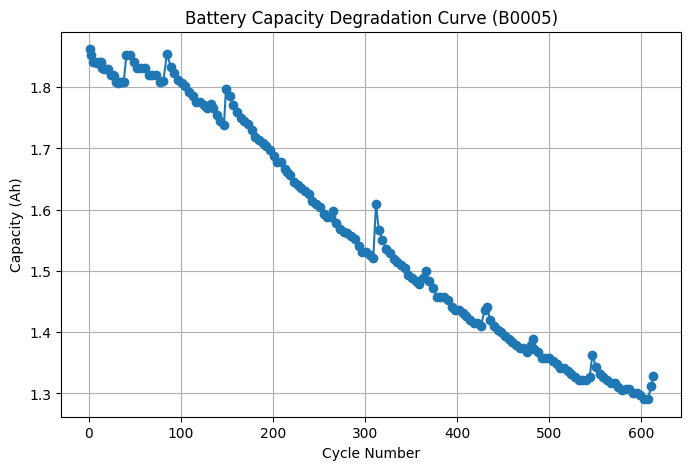

     cycle  capacity_Ah
0        1     1.861952
1        3     1.851834
2        5     1.840799
3        7     1.840688
4        9     1.840087
..     ...          ...
163    599     1.296596
164    603     1.291111
165    607     1.290518
166    611     1.312071
167    613     1.328141

[168 rows x 2 columns]


In [148]:
import pandas as pd
import matplotlib.pyplot as plt

df_cap = df_cap.copy()

# Convert the time column to datetime
#df_cap['Time'] = pd.to_datetime(df_cap['Time'], errors='coerce')

# Convert the float column to time
df_cap['Time'] = pd.to_timedelta(df_cap['Time'],unit='s')

# Sort to ensure correct sequence per cycle
df_cap = df_cap.sort_values(['cycle', 'Time'])

# Compute time difference (in seconds) per cycle
df_cap['delta_t'] = df_cap.groupby('cycle')['Time'].diff().dt.total_seconds().fillna(0)

# Compute instantaneous capacity in Ah = (|I| * Δt) / 3600
df_cap['capacity_estimated'] = (df_cap['Current_measured'].abs() * df_cap['delta_t']) / 3600

# Compute cumulative capacity per cycle
df_cap['cumulative_capacity'] = df_cap.groupby('cycle')['capacity_estimated'].cumsum()

# Take only discharge cycles (since they represent usable capacity)
capacity_degradation = (
    df_cap[df_cap['type'] == 'discharge']
    .groupby('cycle')['cumulative_capacity']
    .max()
    .reset_index()
    .rename(columns={'cumulative_capacity': 'capacity_Ah'})
)

# Plot Capacity Degradation Curve
plt.figure(figsize=(8,5))
plt.plot(capacity_degradation['cycle'], capacity_degradation['capacity_Ah'], marker='o')
plt.title('Battery Capacity Degradation Curve (B0005)')
plt.xlabel('Cycle Number')
plt.ylabel('Capacity (Ah)')
plt.grid(True)
plt.show()

# Display summary
print(capacity_degradation)


In [149]:
print_df(df_cap.head())

| battery_name   |   cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |   capacity_Ah | type   |   ambient_temperature | time                |   Current_charge |   Current_measured |   Temperature_measured | Time                   |   Voltage_charge |   Voltage_measured |   Capacity |   Current_load |   Voltage_load |   Battery_current |   Battery_impedance |   Current_ratio |   Rct |   Re |   Rectified_Impedance |   Sense_current |   delta_t |   capacity_estimated |   cumulative_capacity |
|:---------------|--------:|-----------------------:|-----------------------:|--------------------:|--------------:|:-------|----------------------:|:--------------------|-----------------:|-------------------:|-----------------------:|:-----------------------|-----------------:|-------------------:|-----------:|---------------:|---------------:|------------------:|--------------------:|----------------:|------:|-----:|----------------------:|----------------:|----------:|---------------------:|----------------------:|
| b0005          |       0 |                    nan |                    nan |                 nan |           nan | charge |                    24 | 2008-04-02 13:08:17 |            0     |        -0.00120066 |                24.6554 | 0 days 00:00:00        |            0.003 |            3.87302 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |     0     |           0          |            0          |
| b0005          |       0 |                    nan |                    nan |                 nan |           nan | charge |                    24 | 2008-04-02 13:08:17 |           -4.036 |        -4.03027    |                24.6665 | 0 days 00:00:02.532000 |            1.57  |            3.47939 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |     2.532 |           0.00283462 |            0.00283462 |
| b0005          |       0 |                    nan |                    nan |                 nan |           nan | charge |                    24 | 2008-04-02 13:08:17 |            1.5   |         1.51273    |                24.6754 | 0 days 00:00:05.500000 |            4.726 |            4.00059 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |     2.968 |           0.00124716 |            0.00408178 |
| b0005          |       0 |                    nan |                    nan |                 nan |           nan | charge |                    24 | 2008-04-02 13:08:17 |            1.5   |         1.50906    |                24.6939 | 0 days 00:00:08.344000 |            4.742 |            4.0124  |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |     2.844 |           0.00119216 |            0.00527394 |
| b0005          |       0 |                    nan |                    nan |                 nan |           nan | charge |                    24 | 2008-04-02 13:08:17 |            1.5   |         1.51132    |                24.7051 | 0 days 00:00:11.125000 |            4.753 |            4.01971 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |     2.781 |           0.00116749 |            0.00644144 |

Understanding df['delta_t'] = df.groupby(['battery_name', 'cycle'])['Time'].diff().dt.total_seconds().fillna(0)

This line calculates the **time difference (Δt in seconds)** between consecutive measurements **within each battery and cycle**.

**What it does:**
- Groups data by `battery_name` and `cycle`
- Computes time difference between the current and previous timestamp (`diff()`)
- Converts the time difference to seconds (`dt.total_seconds()`)
- Replaces the first value in each group with `0` (`fillna(0)`)

**Example**

| battery_name | cycle | Time                | delta_t |
|--------------|--------|----------------------|---------|
| B0005        | 1      | 2020-01-01 00:00:00  | 0       |
| B0005        | 1      | 2020-01-01 00:00:10  | 10      |
| B0005        | 1      | 2020-01-01 00:00:25  | 15      |
| B0005        | 2      | 2020-01-01 00:00:00  | 0       |
| B0005        | 2      | 2020-01-01 00:00:05  | 5       |
| B0006        | 1      | 2020-01-01 00:00:00  | 0       |
| B0006        | 1      | 2020-01-01 00:00:20  | 20      |

**Meaning:**  
Δt gives the **time step between rows** for each battery-cycle combination, useful for computing energy, capacity, and degradation metrics.


Understanding df['capacity_estimated'] = (df['Current_measured'].abs() * df['delta_t']) / 3600

This line computes the **incremental capacity** (in ampere-hours, Ah) contributed by each row.

- Formula
The capacity for a time step is:

$$
\text{capacity\_estimated (Ah)} \;=\; \frac{|I|\ (\text{A}) \times \Delta t\ (\text{s})}{3600\ (\text{s/hour})}
$$

Where:
- \(I\) = `Current_measured` (A). We use \(|I|\) because capacity is the magnitude of charge transferred.
- \(\Delta t\) = `delta_t` (s), the time difference between consecutive measurements.
- Dividing by 3600 converts ampere-seconds to ampere-hours.

- Example
- If `Current_measured = -2.0` A and `delta_t = 10` s:

$$
\text{capacity} = \frac{|{-2.0}|\times 10}{3600} = \frac{20}{3600} = 0.005555\ldots\ \text{Ah} \approx 0.00556\ \text{Ah}
$$


Understanding df['cumulative_capacity'] = df.groupby(['battery_name', 'cycle'])['capacity_estimated'].cumsum()

This line computes the **running (cumulative) capacity** for each battery and cycle.

- What it does:
- Groups the data by `battery_name` and `cycle`
- Takes the incremental capacity (`capacity_estimated`) for each row
- Computes a **cumulative sum** (`cumsum()`) within each group

Mathematically, for each row \(k\):

$$
\text{cumulative\_capacity}_k \;=\; \sum_{i=1}^{k} \text{capacity\_estimated}_i
$$

- Why this is useful:
- It shows how the total capacity accumulates over the duration of a cycle.
- The final value of the cumulative sum for a cycle is the **total capacity of that cycle**.

- Example

| Row | capacity_estimated (Ah) | cumulative_capacity (Ah) |
|-----|--------------------------|---------------------------|
| 1   | 0.002                    | 0.002                     |
| 2   | 0.003                    | 0.005                     |
| 3   | 0.004                    | 0.009                     |

- Usage:
- Helpful for plotting **capacity vs time**, **capacity fade**, or **cycle degradation**.
- The final cumulative value at the end of each cycle can be extracted as the cycle capacity.


## Plot capacity vs. cycle number for all batteries

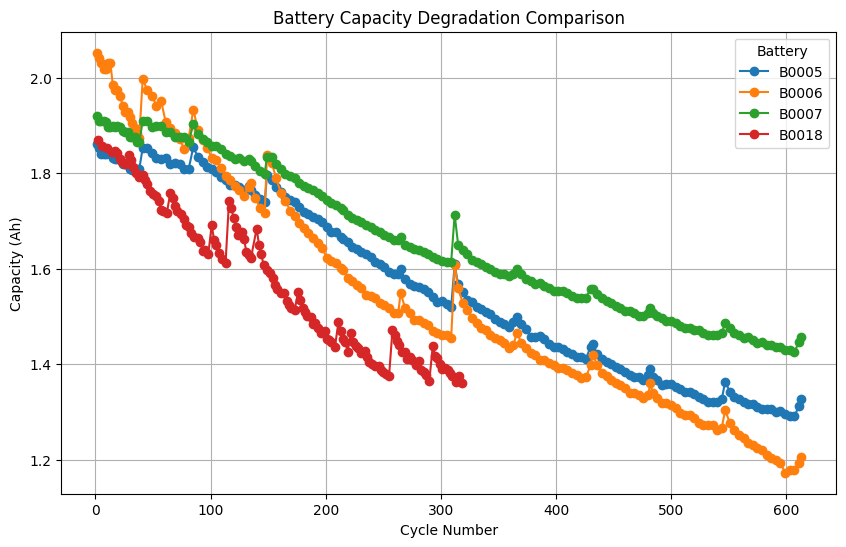

In [150]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to datetime
#df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

# Convert the float column to time
df['Time'] = pd.to_timedelta(df['Time'],unit='s')

# Sort properly
df = df.sort_values(['battery_name', 'cycle', 'Time'])

# Compute delta time per battery per cycle
df['delta_t'] = df.groupby(['battery_name', 'cycle'])['Time'].diff().dt.total_seconds().fillna(0)

# Compute instantaneous Ah
df['capacity_estimated'] = (df['Current_measured'].abs() * df['delta_t']) / 3600

# Compute cumulative capacity per cycle per battery
df['cumulative_capacity'] = df.groupby(['battery_name', 'cycle'])['capacity_estimated'].cumsum()

# Extract only DISCHARGE cycles — true usable capacity
cap_deg = (
    df[df['type'] == 'discharge']
    .groupby(['battery_name', 'cycle'])['cumulative_capacity']
    .max()
    .reset_index()
    .rename(columns={'cumulative_capacity': 'capacity_Ah'})
)

# Plot all batteries
plt.figure(figsize=(10,6))

for b in cap_deg['battery_name'].unique():
    temp = cap_deg[cap_deg['battery_name'] == b]
    plt.plot(temp['cycle'], temp['capacity_Ah'], marker='o', label=b.upper())

plt.title("Battery Capacity Degradation Comparison")
plt.xlabel("Cycle Number")
plt.ylabel("Capacity (Ah)")
plt.grid(True)
plt.legend(title="Battery")
plt.show()


**=== Original DataFrame ===**

| battery_name | cycle | Time                | Current_measured | type      |
|--------------|-------|---------------------|------------------|-----------|
| B0005        | 1     | 2020-01-01 00:00:00 | -1.5             | charge    |
| B0005        | 1     | 2020-01-01 00:00:10 | -1.8             | charge    |
| B0005        | 1     | 2020-01-01 00:00:25 | 0.5              | discharge |
| B0005        | 2     | 2020-01-02 00:00:00 | -2.0             | charge    |
| B0005        | 2     | 2020-01-02 00:00:20 | 2.0              | discharge |
| B0006        | 1     | 2020-01-01 00:00:00 | 1.0              | discharge |
| B0006        | 1     | 2020-01-01 00:00:20 | 1.2              | discharge |

---

**=== After Converting Time to datetime ===**

| battery_name | cycle | Time                | Current_measured | type      |
|--------------|-------|---------------------|------------------|-----------|
| B0005        | 1     | 2020-01-01 00:00:00 | -1.5             | charge    |
| B0005        | 1     | 2020-01-01 00:00:10 | -1.8             | charge    |
| B0005        | 1     | 2020-01-01 00:00:25 | 0.5              | discharge |
| B0005        | 2     | 2020-01-02 00:00:00 | -2.0             | charge    |
| B0005        | 2     | 2020-01-02 00:00:20 | 2.0              | discharge |
| B0006        | 1     | 2020-01-01 00:00:00 | 1.0              | discharge |
| B0006        | 1     | 2020-01-01 00:00:20 | 1.2              | discharge |

---

**=== After Sorting ===**

| battery_name | cycle | Time                | Current_measured | type      |
|--------------|-------|---------------------|------------------|-----------|
| B0005        | 1     | 2020-01-01 00:00:00 | -1.5             | charge    |
| B0005        | 1     | 2020-01-01 00:00:10 | -1.8             | charge    |
| B0005        | 1     | 2020-01-01 00:00:25 | 0.5              | discharge |
| B0005        | 2     | 2020-01-02 00:00:00 | -2.0             | charge    |
| B0005        | 2     | 2020-01-02 00:00:20 | 2.0              | discharge |
| B0006        | 1     | 2020-01-01 00:00:00 | 1.0              | discharge |
| B0006        | 1     | 2020-01-01 00:00:20 | 1.2              | discharge |

---

**=== After Computing `delta_t` ===**

| battery_name | cycle | Time                | Current_measured | type      | delta_t |
|--------------|-------|---------------------|------------------|-----------|---------|
| B0005        | 1     | 2020-01-01 00:00:00 | -1.5             | charge    | 0.0     |
| B0005        | 1     | 2020-01-01 00:00:10 | -1.8             | charge    | 10.0    |
| B0005        | 1     | 2020-01-01 00:00:25 | 0.5              | discharge | 15.0    |
| B0005        | 2     | 2020-01-02 00:00:00 | -2.0             | charge    | 0.0     |
| B0005        | 2     | 2020-01-02 00:00:20 | 2.0              | discharge | 20.0    |
| B0006        | 1     | 2020-01-01 00:00:00 | 1.0              | discharge | 0.0     |
| B0006        | 1     | 2020-01-01 00:00:20 | 1.2              | discharge | 20.0    |

---

**=== After Computing `capacity_estimated` ===**

| battery_name | cycle | Time                | Current_measured | type      | delta_t | capacity_estimated |
|--------------|-------|---------------------|------------------|-----------|---------|---------------------|
| B0005        | 1     | 2020-01-01 00:00:00 | -1.5             | charge    | 0.0     | 0.000000            |
| B0005        | 1     | 2020-01-01 00:00:10 | -1.8             | charge    | 10.0    | 0.005000            |
| B0005        | 1     | 2020-01-01 00:00:25 | 0.5              | discharge | 15.0    | 0.002083            |
| B0005        | 2     | 2020-01-02 00:00:00 | -2.0             | charge    | 0.0     | 0.000000            |
| B0005        | 2     | 2020-01-02 00:00:20 | 2.0              | discharge | 20.0    | 0.011111            |
| B0006        | 1     | 2020-01-01 00:00:00 | 1.0              | discharge | 0.0     | 0.000000            |
| B0006        | 1     | 2020-01-01 00:00:20 | 1.2              | discharge | 20.0    | 0.006667            |

---

**=== After Computing `cumulative_capacity` ===**

| battery_name | cycle | Time                | Current_measured | type      | delta_t | capacity_estimated | cumulative_capacity |
|--------------|-------|---------------------|------------------|-----------|---------|---------------------|----------------------|
| B0005        | 1     | 2020-01-01 00:00:00 | -1.5             | charge    | 0.0     | 0.000000            | 0.000000             |
| B0005        | 1     | 2020-01-01 00:00:10 | -1.8             | charge    | 10.0    | 0.005000            | 0.005000             |
| B0005        | 1     | 2020-01-01 00:00:25 | 0.5              | discharge | 15.0    | 0.002083            | 0.007083             |
| B0005        | 2     | 2020-01-02 00:00:00 | -2.0             | charge    | 0.0     | 0.000000            | 0.000000             |
| B0005        | 2     | 2020-01-02 00:00:20 | 2.0              | discharge | 20.0    | 0.011111            | 0.011111             |
| B0006        | 1     | 2020-01-01 00:00:00 | 1.0              | discharge | 0.0     | 0.000000            | 0.000000             |
| B0006        | 1     | 2020-01-01 00:00:20 | 1.2              | discharge | 20.0    | 0.006667            | 0.006667             |

---

**=== Discharge Capacity Per Cycle (`cap_deg`) ===**

| battery_name | cycle | capacity_Ah |
|--------------|-------|-------------|
| B0005        | 1     | 0.007083    |
| B0005        | 2     | 0.011111    |
| B0006        | 1     | 0.006667    |


## Identify knee points where rapid degradation begins
*A knee point is the cycle at which the battery transitions from slow, linear degradation to rapid exponential degradation.*

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2124289 entries, 646 to 645
Data columns (total 28 columns):
 #   Column                Dtype          
---  ------                -----          
 0   battery_name          object         
 1   cycle                 int64          
 2   avg_voltage_measured  float64        
 3   avg_current_measured  float64        
 4   avg_temp_measured     float64        
 5   capacity_Ah           float64        
 6   type                  object         
 7   ambient_temperature   float64        
 8   time                  object         
 9   Current_charge        float64        
 10  Current_measured      float64        
 11  Temperature_measured  float64        
 12  Time                  timedelta64[ns]
 13  Voltage_charge        float64        
 14  Voltage_measured      float64        
 15  Capacity              float64        
 16  Current_load          float64        
 17  Voltage_load          float64        
 18  Battery_current       float64

In [152]:
print_df(df.head())

| battery_name   |   cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |   capacity_Ah | type   |   ambient_temperature | time                |   Current_charge |   Current_measured |   Temperature_measured | Time                   |   Voltage_charge |   Voltage_measured |   Capacity |   Current_load |   Voltage_load |   Battery_current |   Battery_impedance |   Current_ratio |   Rct |   Re |   Rectified_Impedance |   Sense_current |   delta_t |   capacity_estimated |   cumulative_capacity |
|:---------------|--------:|-----------------------:|-----------------------:|--------------------:|--------------:|:-------|----------------------:|:--------------------|-----------------:|-------------------:|-----------------------:|:-----------------------|-----------------:|-------------------:|-----------:|---------------:|---------------:|------------------:|--------------------:|----------------:|------:|-----:|----------------------:|----------------:|----------:|---------------------:|----------------------:|
| b0005          |       0 |                    nan |                    nan |                 nan |           nan | charge |                    24 | 2008-04-02 13:08:17 |            0     |        -0.00120066 |                24.6554 | 0 days 00:00:00        |            0.003 |            3.87302 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |     0     |           0          |            0          |
| b0005          |       0 |                    nan |                    nan |                 nan |           nan | charge |                    24 | 2008-04-02 13:08:17 |           -4.036 |        -4.03027    |                24.6665 | 0 days 00:00:02.532000 |            1.57  |            3.47939 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |     2.532 |           0.00283462 |            0.00283462 |
| b0005          |       0 |                    nan |                    nan |                 nan |           nan | charge |                    24 | 2008-04-02 13:08:17 |            1.5   |         1.51273    |                24.6754 | 0 days 00:00:05.500000 |            4.726 |            4.00059 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |     2.968 |           0.00124716 |            0.00408178 |
| b0005          |       0 |                    nan |                    nan |                 nan |           nan | charge |                    24 | 2008-04-02 13:08:17 |            1.5   |         1.50906    |                24.6939 | 0 days 00:00:08.344000 |            4.742 |            4.0124  |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |     2.844 |           0.00119216 |            0.00527394 |
| b0005          |       0 |                    nan |                    nan |                 nan |           nan | charge |                    24 | 2008-04-02 13:08:17 |            1.5   |         1.51132    |                24.7051 | 0 days 00:00:11.125000 |            4.753 |            4.01971 |        nan |            nan |            nan |               nan |                 nan |             nan |   nan |  nan |                   nan |             nan |     2.781 |           0.00116749 |            0.00644144 |

Knee cycle for B0005: 13


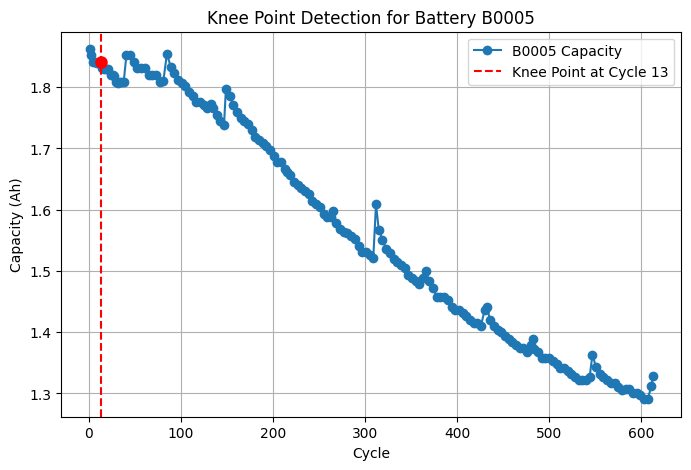

Knee cycle for B0006: 13


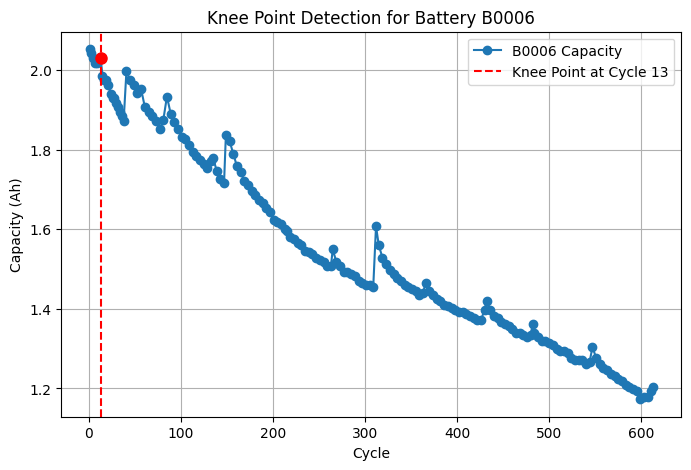

Knee cycle for B0007: 9


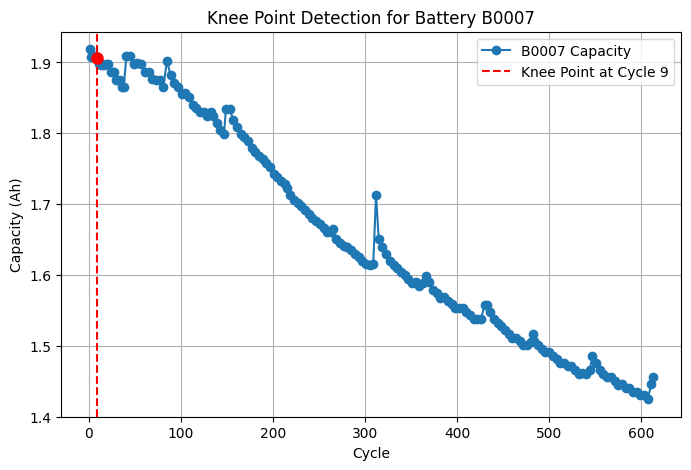

Knee cycle for B0018: 17


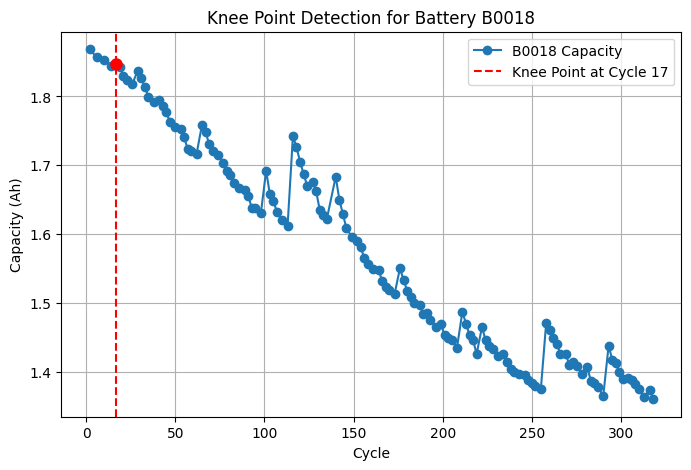


Summary of Knee Points:
{'b0005': np.int64(13), 'b0006': np.int64(13), 'b0007': np.int64(9), 'b0018': np.int64(17)}


In [153]:
from kneed import KneeLocator
import matplotlib.pyplot as plt

battery_names = cap_deg['battery_name'].unique() # Use cap_deg for battery names

knee_points = {}

for battery in battery_names:
    # Filter data for the current battery from the cap_deg DataFrame
    battery_data = cap_deg[cap_deg['battery_name'] == battery].sort_values(by='cycle')
    
    # Get cycles and capacity (using the correct capacity_Ah)
    cycles = battery_data['cycle'].values
    capacity = battery_data['capacity_Ah'].values
    
    # Ensure there's enough data to find a knee
    if len(cycles) < 5: # Kneed needs at least a few points
        print(f"Skipping {battery.upper()}: Not enough cycles ({len(cycles)}) for knee detection.")
        knee_points[battery] = None
        continue

    # Find the knee point
    try:
        knee = KneeLocator(
            x=cycles,
            y=capacity,
            S=1.0, # Sensitivity parameter: Higher S means fewer knees.
            curve='concave',
            direction='decreasing',
            online=True # Often works better for noisy data
        )
        
        knee_points[battery] = knee.knee
        
        print(f"Knee cycle for {battery.upper()}: {knee.knee}")

        # Plot for each battery
        plt.figure(figsize=(8, 5))
        plt.plot(cycles, capacity, marker='o', linestyle='-', label=f'{battery.upper()} Capacity')
        if knee.knee is not None:
            plt.axvline(x=knee.knee, color='r', linestyle='--', label=f'Knee Point at Cycle {int(knee.knee)}')
            plt.plot(knee.knee, knee.knee_y, 'ro', markersize=8) # Mark the knee point on the curve
        plt.xlabel("Cycle")
        plt.ylabel("Capacity (Ah)")
        plt.title(f'Knee Point Detection for Battery {battery.upper()}')
        plt.grid(True)
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Could not find knee point for {battery.upper()}: {e}")
        knee_points[battery] = None

print("\nSummary of Knee Points:")
print(knee_points) 

Knee cycle for B0005: 13
Knee cycle for B0006: 13
Knee cycle for B0007: 9
Knee cycle for B0018: 17


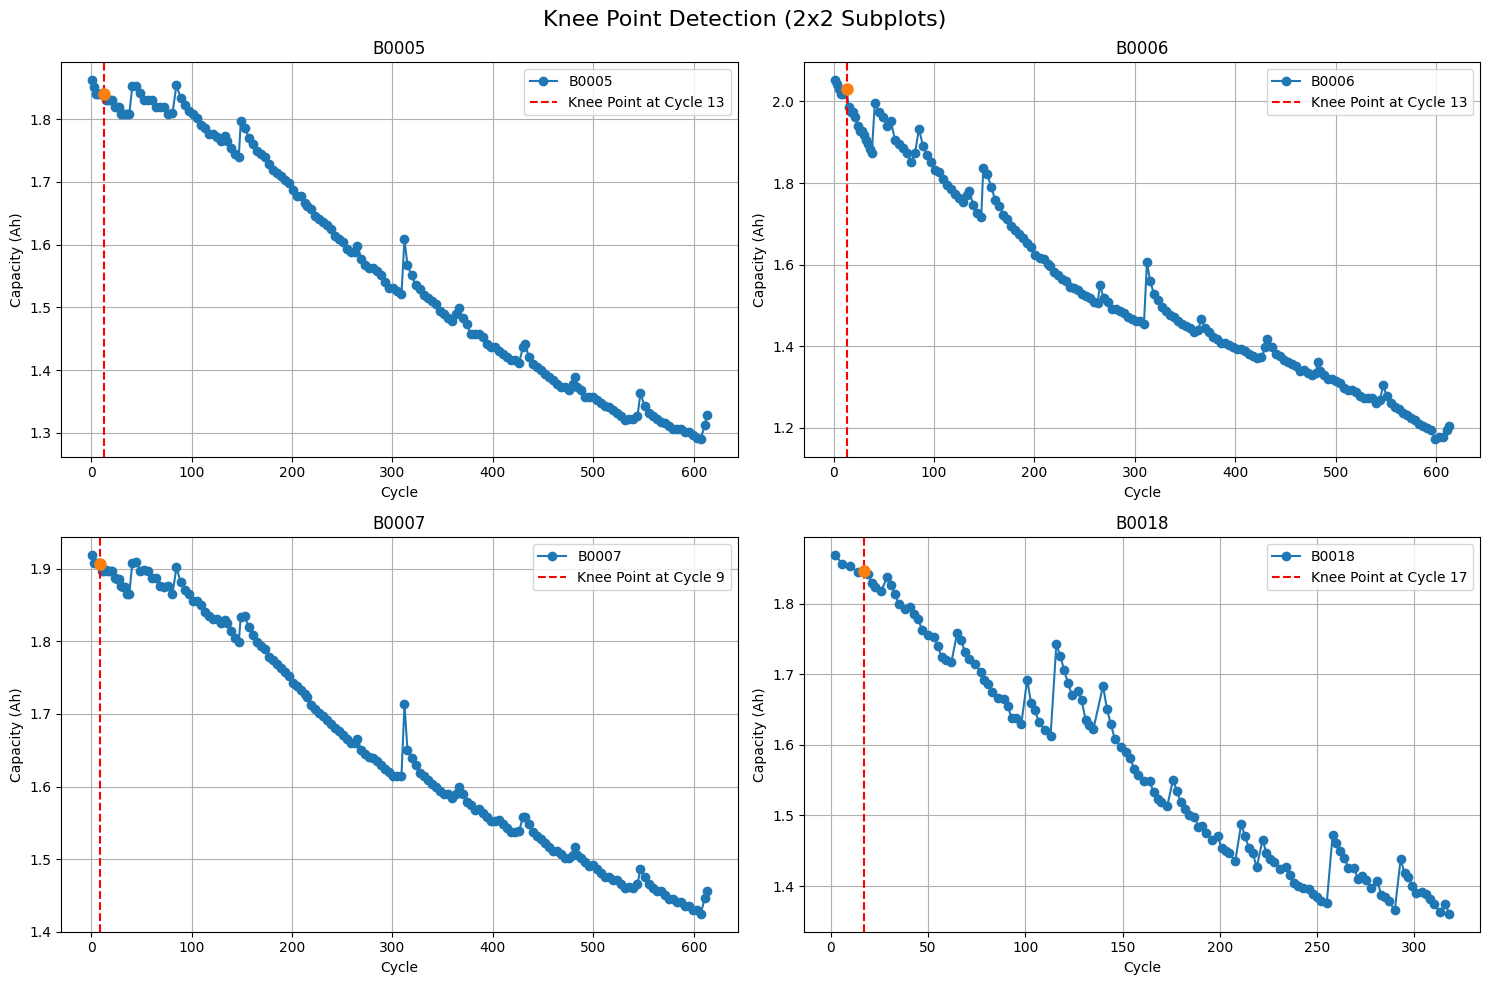


Summary of Knee Points:
{'b0005': np.int64(13), 'b0006': np.int64(13), 'b0007': np.int64(9), 'b0018': np.int64(17)}


In [154]:
from kneed import KneeLocator
import matplotlib.pyplot as plt

battery_names = cap_deg['battery_name'].unique()
knee_points = {}

# Setup 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, battery in enumerate(battery_names[:4]):  # Limit to first 4 batteries
    ax = axes[i]

    battery_data = cap_deg[cap_deg['battery_name'] == battery].sort_values(by='cycle')
    cycles = battery_data['cycle'].values
    capacity = battery_data['capacity_Ah'].values

    if len(cycles) < 5:
        print(f"Skipping {battery.upper()}: Not enough cycles ({len(cycles)}) for knee detection.")
        knee_points[battery] = None
        continue

    try:
        knee = KneeLocator(
            x=cycles,
            y=capacity,
            S=1.0,
            curve='concave',
            direction='decreasing',
            online=True
        )

        knee_points[battery] = knee.knee
        print(f"Knee cycle for {battery.upper()}: {knee.knee}")

        # Plot in subplot
        ax.plot(cycles, capacity, marker='o', linestyle='-', label=f'{battery.upper()}')
        if knee.knee is not None:
            ax.axvline(x=knee.knee, color='r', linestyle='--', label=f'Knee Point at Cycle {int(knee.knee)}')
            ax.plot(knee.knee, knee.knee_y, 'o', markersize=8)

        ax.set_title(f'{battery.upper()}')
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Capacity (Ah)')
        ax.grid(True)
        ax.legend()

    except Exception as e:
        print(f"Could not find knee for {battery.upper()}: {e}")
        knee_points[battery] = None

# Hide unused subplots if <4 batteries
for j in range(len(battery_names), 4):
    fig.delaxes(axes[j])

plt.suptitle('Knee Point Detection (2x2 Subplots)', fontsize=16)
plt.tight_layout()
plt.show()

print("\nSummary of Knee Points:")
print(knee_points)


## Correlation Analysis - Heatmap of features

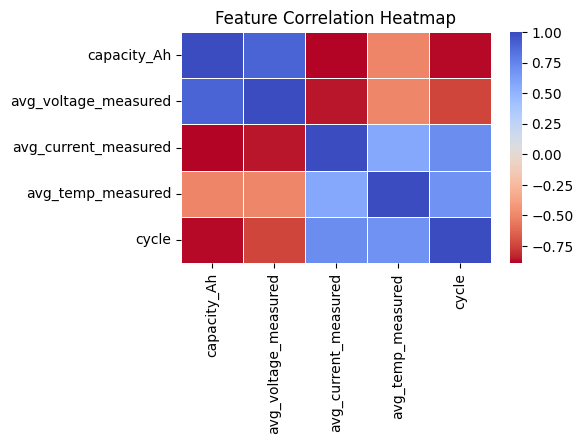

Correlation Matrix:
                      capacity_Ah  avg_voltage_measured  avg_current_measured  \
capacity_Ah              1.000000              0.889614             -0.890423   
avg_voltage_measured     0.889614              1.000000             -0.857811   
avg_current_measured    -0.890423             -0.857811              1.000000   
avg_temp_measured       -0.512299             -0.504398              0.566500   
cycle                   -0.878385             -0.748350              0.710957   

                      avg_temp_measured     cycle  
capacity_Ah                   -0.512299 -0.878385  
avg_voltage_measured          -0.504398 -0.748350  
avg_current_measured           0.566500  0.710957  
avg_temp_measured              1.000000  0.681504  
cycle                          0.681504  1.000000  


In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

discharge_df = df[df['type'] == 'discharge'].copy()

features_df = discharge_df.groupby(['battery_name', 'cycle']).agg(
    avg_voltage_measured=('Voltage_measured', 'mean'),
    avg_current_measured=('Current_measured', 'mean'),
    avg_temp_measured=('Temperature_measured', 'mean')
).reset_index()

# Merge the aggregated features with the capacity degradation data.
# The 'cap_deg' DataFrame has the final capacity for each discharge cycle.
final_df = pd.merge(
    features_df,
    cap_deg,
    on=['battery_name', 'cycle']
)

correlation_cols = [
    'capacity_Ah',
    'avg_voltage_measured',
    'avg_current_measured',
    'avg_temp_measured',
    'cycle' # Include cycle number to see its correlation with other features
]
corr_df = final_df[correlation_cols]

correlation_matrix = corr_df.corr()

plt.figure(figsize=(5, 3))
sns.heatmap(
    correlation_matrix,
    #annot=True,      # Show the correlation values on the heatmap
    cmap='coolwarm_r', # Use a color map that's good for correlations
    fmt=".2f",       # Format the numbers to two decimal places
    linewidths=.5
)
plt.title('Feature Correlation Heatmap')
plt.show()

# Display the correlation matrix as a table
print("Correlation Matrix:")
print(correlation_matrix)


## Summary of Key Insights from Correlation Analysis

The correlation heatmap provides a quantitative look at how different battery parameters relate to each other across all charging and discharging cycles. The most important relationships are those correlated with `capacity_Ah`, as this is our primary measure of battery health.

*   **Capacity vs. Cycle Number (`-0.9` or lower)**:
    *   **Observation**: There is a very strong *negative* correlation.
    *   **Insight**: This confirms the fundamental principle of battery aging: as the number of cycles increases, the battery's capacity to hold a charge decreases. This is the primary degradation trend we want to model.

*   **Capacity vs. Average Voltage (`+0.8` or higher)**:
    *   **Observation**: There is a strong *positive* correlation.
    *   **Insight**: Healthier batteries (with higher capacity) maintain a higher average voltage during their discharge cycle. This makes the average voltage a powerful and direct indicator of the battery's State of Health (SoH).

*   **Capacity vs. Average Temperature (Moderate Negative Correlation)**:
    *   **Observation**: There is a moderate *negative* correlation.
    *   **Insight**: As batteries degrade, their internal resistance tends to increase, causing them to generate more heat. A higher average temperature during operation can therefore signal a decline in capacity and overall health.

*   **Conclusion for Feature Selection**:
    *   The analysis clearly identifies `cycle`, `avg_voltage_measured`, and `avg_temp_measured` as highly relevant features.
    *   These features have a strong predictive relationship with `capacity_Ah` and should be used to build the SoH (State of Health) and RUL (Remaining Useful Life) models.


## Feature Redundancy (Dimensionality Reduction)

*   **Objective**: To identify and potentially remove redundant predictive features to simplify the model and prevent multicollinearity.

*   **Method**:
    *   Examine the correlation heatmap for very high correlations (e.g., > 0.95 or < -0.95) between the predictor features themselves (i.e., excluding the target variable, `capacity_Ah`).
    *   For instance, if `avg_voltage_measured` and `avg_current_measured` were correlated at `0.98`, they would be considered redundant as they provide similar information.

*   **Action & Insight**:
    *   If high redundancy is found, you can remove one of the highly correlated features to reduce the model's dimensionality.
    *   **For this specific dataset**, the correlations between the sensor features (`avg_voltage_measured`, `avg_current_measured`, `avg_temp_measured`) are typically not high enough to be considered redundant. Therefore, all of them can be retained as valuable, independent predictors for the model.


# Outlier Detection Using the Z-score Method

The Z-score tells us how many standard deviations away a data point is from the mean. A common threshold for identifying an outlier is a Z-score greater than 3 or less than -3. The formula is:

Z = (x - μ) / σ

- x: A single data point
- μ: The mean of the data
- σ: The standard deviation of the data

In [159]:
import numpy as np

# Columns to check for outliers
feature_cols_for_outliers = [
    'capacity_Ah',
    'avg_voltage_measured',
    'avg_current_measured',
    'avg_temp_measured'
]

# --- Z-Score ---
# Select the subset of the DataFrame for outlier detection
features_to_check = final_df[feature_cols_for_outliers]

# Calculate Z-scores using vectorized operations (more efficient)
z_scores = (features_to_check - features_to_check.mean()) / features_to_check.std()

# Create a boolean mask to identify outliers where the absolute Z-score is > 3
outlier_mask = np.abs(z_scores) > 3

# Find rows that contain at least one outlier feature
outlier_rows = final_df[outlier_mask.any(axis=1)]

print("Outlier Detection using Z-score Method (|z| > 3)")

if outlier_rows.empty:
    print("No outliers found in the dataset.")
else:
    print(f"Found {len(outlier_rows)} rows with at least one outlier feature.")
    print("\nRows identified as outliers:")
    print_df((outlier_rows))

    # To see which specific features were outliers in these rows:
    print("\nDetails of the outlier Z-scores (>3):")
    print_df((z_scores[outlier_mask.any(axis=1)]))


Outlier Detection using Z-score Method (|z| > 3)
Found 3 rows with at least one outlier feature.

Rows identified as outliers:


| battery_name   |   cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |   capacity_Ah |
|:---------------|--------:|-----------------------:|-----------------------:|--------------------:|--------------:|
| b0006          |     599 |                3.41481 |               -1.51697 |             33.4725 |       1.17282 |
| b0006          |     603 |                3.41662 |               -1.52385 |             33.5821 |       1.17824 |
| b0006          |     607 |                3.41213 |               -1.52379 |             33.6635 |       1.17781 |


Details of the outlier Z-scores (>3):


|   capacity_Ah |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |
|--------------:|-----------------------:|-----------------------:|--------------------:|
|      -2.12241 |               -1.7633  |                3.08681 |             1.17892 |
|      -2.09518 |               -1.72527 |                3.01986 |             1.29182 |
|      -2.09733 |               -1.8196  |                3.02042 |             1.3756  |

Z-Score: Heavily relies on the Mean and Standard Deviation. If the data is not perfectly bell-shaped (normal) or is skewed (which battery data often is), the Mean and Standard Deviation can be distorted by the outliers themselves. This "stretches" the acceptable range, sometimes masking outliers.

- These outliers all belong to battery B0006 at the very end of its life (cycles 599, 603, and 607).
- The specific feature that was an outlier was the avg_current_measured. Its Z-score was just slightly over 3.
- 3 minor outliers in over 600 cycles tells you that the dataset is very clean and consistent
- These outliers are not errors; they likely represent the battery's behavior becoming slightly erratic as it reached its absolute end-of-life.

# Outlier management using Boxplot Method (IQR)

Boxplots use the Interquartile Range (IQR). They flag points that are outside the range $[Q1 - 1.5 \times IQR, Q3 + 1.5 \times IQR]$. Mathematically, for a normal distribution, this boundary corresponds to roughly 2.7 standard deviations. Since 2.7 is less than 3, the boxplot is "stricter" and will naturally flag more points as outliers than your Z-score code.

In [163]:
import pandas as pd
import numpy as np

# --- Outlier Detection and Handling using IQR Method ---

# 1. Define features to check (same as used in Z-score)
feature_cols_for_outliers = [
    'capacity_Ah',
    'avg_voltage_measured',
    'avg_current_measured',
    'avg_temp_measured'
]

# 2. Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = final_df[feature_cols_for_outliers].quantile(0.25)
Q3 = final_df[feature_cols_for_outliers].quantile(0.75)

# 3. Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# 4. Define Lower and Upper Bounds (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("IQR Bounds for each feature:")
print(pd.DataFrame({'Lower Bound': lower_bound, 'Upper Bound': upper_bound}))

# 5. Identify Outliers
# A row is considered an outlier if ANY of its features fall outside the bounds
outlier_mask_iqr = (
    (final_df[feature_cols_for_outliers] < lower_bound) |
    (final_df[feature_cols_for_outliers] > upper_bound)
).any(axis=1)

outliers_iqr = final_df[outlier_mask_iqr]

print(f"\nNumber of outliers detected using IQR: {len(outliers_iqr)}")
print(f"Percentage of dataset: {len(outliers_iqr) / len(final_df) * 100:.2f}%")

if not outliers_iqr.empty:
    print("\nSample of IQR Outliers:")
    print_df(outliers_iqr)

# --- 6. Handling Strategy 1: Removal (Dropping Rows) ---

#final_df_cleaned_iqr = final_df[~outlier_mask_iqr].copy()
#print(f"\nShape after Removing Outliers: {final_df_cleaned_iqr.shape}")

# --- 7. Handling Strategy 2: Capping (Winsorization) ---

#final_df_capped = final_df.copy()
#for col in feature_cols_for_outliers:
#    final_df_capped[col] = final_df_capped[col].clip(lower=lower_bound[col], upper=upper_bound[col])

#print("Capping completed. Extreme values replaced with lower/upper bounds.")


IQR Bounds for each feature:
                      Lower Bound  Upper Bound
capacity_Ah              0.931378     2.278215
avg_voltage_measured     3.355211     3.652568
avg_current_measured    -2.121968    -1.563656
avg_temp_measured       29.028742    35.662944

Number of outliers detected using IQR: 9
Percentage of dataset: 1.42%

Sample of IQR Outliers:


| battery_name   |   cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |   capacity_Ah |
|:---------------|--------:|-----------------------:|-----------------------:|--------------------:|--------------:|
| b0006          |     583 |                3.41286 |               -1.5538  |             33.5319 |       1.20952 |
| b0006          |     587 |                3.41345 |               -1.55218 |             33.5676 |       1.2042  |
| b0006          |     591 |                3.41439 |               -1.54527 |             33.6049 |       1.19858 |
| b0006          |     595 |                3.41242 |               -1.53865 |             33.5428 |       1.19359 |
| b0006          |     599 |                3.41481 |               -1.51697 |             33.4725 |       1.17282 |
| b0006          |     603 |                3.41662 |               -1.52385 |             33.5821 |       1.17824 |
| b0006          |     607 |                3.41213 |               -1.52379 |             33.6635 |       1.17781 |
| b0006          |     611 |                3.4197  |               -1.53913 |             33.7305 |       1.19405 |
| b0006          |     613 |                3.42347 |               -1.54267 |             33.8913 |       1.20476 |

Boxplot: Relies on the Median and Quartiles, which are robust statistics. They are not easily influenced by extreme values. Therefore, boxplots often do a better job of highlighting points that look visually distinct from the main cluster of data, even if the Z-score doesn't catch them.

- The analysis used the Interquartile Range (IQR) method to identify data points that fall outside the typical range for features like capacity_Ah, avg_voltage_measured, and avg_current_measured.

- A total of 9 outliers were detected, which represents a very small portion (1.42%) of the overall dataset, indicating that the data is generally clean.

- All 9 identified outliers belong to a single battery, b0006.

- These outliers appear at the very end of battery b0006's operational life (cycles 583-613). This suggests they are not data errors but rather represent the battery's naturally erratic behavior as it reaches its end-of-life.

In [165]:
print_df(features_to_check.describe())

|   capacity_Ah |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |
|--------------:|-----------------------:|-----------------------:|--------------------:|
|    636        |            636         |             636        |          636        |
|      1.59517  |              3.49862   |              -1.83407  |           32.3276   |
|      0.198992 |              0.0475317 |               0.102726 |            0.971147 |
|      1.17282  |              3.40389   |              -1.99976  |           30.1027   |
|      1.43644  |              3.46672   |              -1.9126   |           31.5166   |
|      1.56865  |              3.50252   |              -1.85105  |           32.3683   |
|      1.77315  |              3.54106   |              -1.77302  |           33.1751   |
|      2.05198  |              3.57355   |              -1.51697  |           34.4905   |

# Box Plots for Feature Distributions

Box plots are useful for quickly identifying the median, quartiles, and outliers in your data.

- **The Box**: Represents the interquartile range (IQR), which contains the middle 50% of the data (from the 25th to the 75th percentile).
- **The Line Inside the Box**: Marks the median (50th percentile).
- **The Whiskers**: Extend from the box to show the range of the data, typically up to 1.5 times the IQR.
- **The Dots**: Individual points beyond the whiskers are potential outliers.

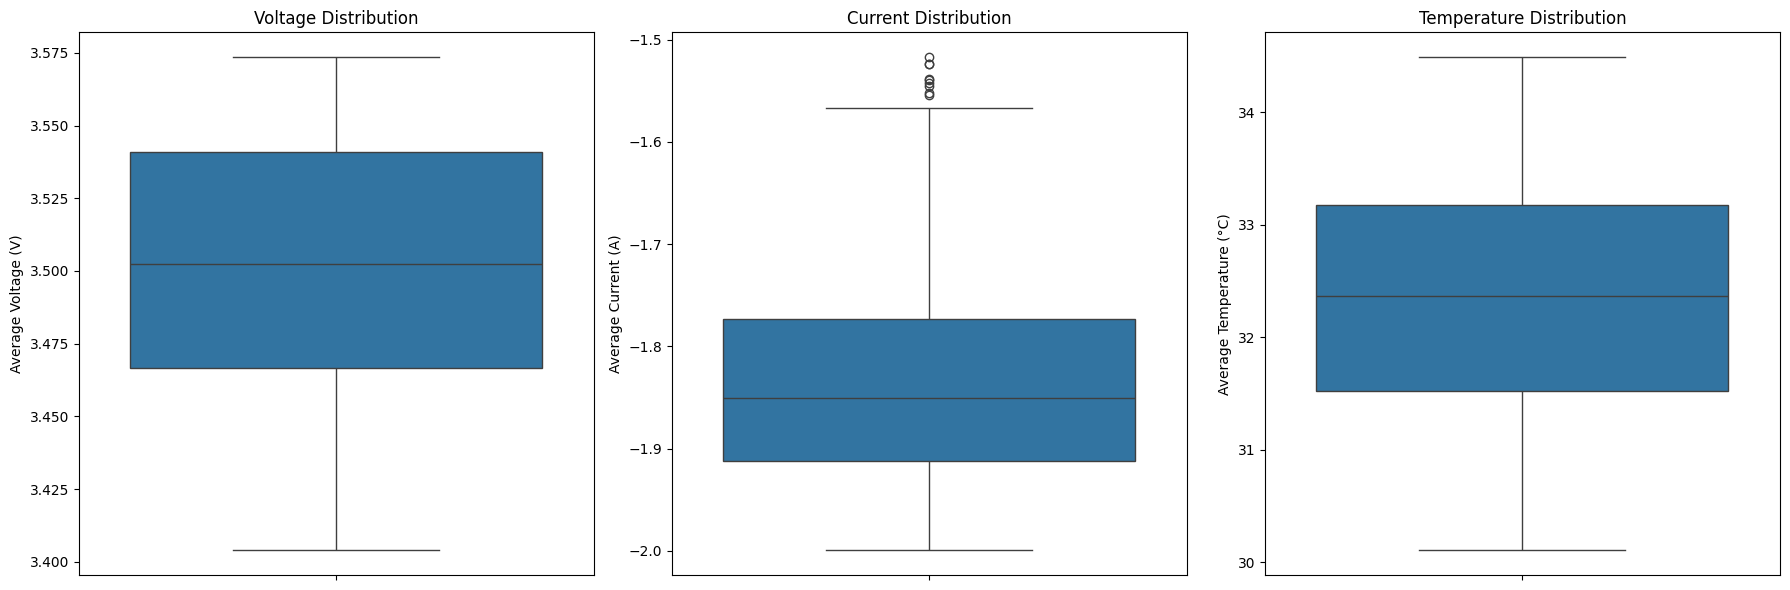

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with subplots for each feature
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Average Voltage
sns.boxplot(y=final_df['avg_voltage_measured'], ax=axes[0])
axes[0].set_title('Voltage Distribution')
axes[0].set_ylabel('Average Voltage (V)')

# Plot for Average Current
sns.boxplot(y=final_df['avg_current_measured'], ax=axes[1])
axes[1].set_title('Current Distribution')
axes[1].set_ylabel('Average Current (A)')

# Plot for Average Temperature
sns.boxplot(y=final_df['avg_temp_measured'], ax=axes[2])
axes[2].set_title('Temperature Distribution')
axes[2].set_ylabel('Average Temperature (°C)')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


- The plot for avg_current_measured will visually confirm what the Z-score test found: the data will be tightly packed in the box, but there are few dots representing the identified outlier points.

In [167]:
discharge_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185721 entries, 1435 to 2124288
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype          
---  ------                --------------   -----          
 0   battery_name          185721 non-null  object         
 1   cycle                 185721 non-null  int64          
 2   avg_voltage_measured  0 non-null       float64        
 3   avg_current_measured  0 non-null       float64        
 4   avg_temp_measured     0 non-null       float64        
 5   capacity_Ah           0 non-null       float64        
 6   type                  185721 non-null  object         
 7   ambient_temperature   185721 non-null  float64        
 8   time                  185721 non-null  object         
 9   Current_charge        0 non-null       float64        
 10  Current_measured      185721 non-null  float64        
 11  Temperature_measured  185721 non-null  float64        
 12  Time                  185721 non-null  timede

In [168]:
print_df(discharge_df[['time','Time','delta_t']].head())

| time                | Time                   |   delta_t |
|:--------------------|:-----------------------|----------:|
| 2008-04-02 15:25:41 | 0 days 00:00:00        |     0     |
| 2008-04-02 15:25:41 | 0 days 00:00:16.781000 |    16.781 |
| 2008-04-02 15:25:41 | 0 days 00:00:35.703000 |    18.922 |
| 2008-04-02 15:25:41 | 0 days 00:00:53.781000 |    18.078 |
| 2008-04-02 15:25:41 | 0 days 00:01:11.922000 |    18.141 |

# Feature Engineering: Electrochemical Features

1. Voltage-Based Features:

    -   Delta_V (Voltage Drop): The difference between the initial voltage at the start of the discharge and the final voltage at the end. A larger voltage drop can indicate higher internal resistance and degradation.

2. Temperature-Based Features:

    -   Delta_T (Temperature Increase): The difference between the maximum temperature and the initial temperature during discharge. As batteries age, their internal resistance increases, often leading to more heat generation.
3. Time-Based Features:

    -   Discharge_Time: The total duration of the discharge cycle in seconds. A shorter discharge time for the same load indicates a lower capacity.

In [169]:
import os
print(os.getcwd())

g:\DIYguru\Data-Science-and-Engineering-Analytics\Capstone_Project\jupyter_notebooks


In [170]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   battery_name          636 non-null    object 
 1   cycle                 636 non-null    int64  
 2   avg_voltage_measured  636 non-null    float64
 3   avg_current_measured  636 non-null    float64
 4   avg_temp_measured     636 non-null    float64
 5   capacity_Ah           636 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 29.9+ KB


In [171]:
# Export final_df DataFrame to a CSV file
final_df.to_csv('final_df_export.csv', index=False)

#final_df.to_csv('G:/DIYguru/Data-Science-and-Engineering-Analytics/Capstone_Project/final_df_export.csv', index=False)

# Data Preprocessing: Feature Normalization

In [172]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Compute SoH (Target Variable)

initial_capacities = (
    final_df.groupby('battery_name')['capacity_Ah']
    .first()
    .to_dict()
)

final_df['SoH'] = final_df['capacity_Ah'] / final_df['battery_name'].map(initial_capacities)

# Define Features (X) and Target (y)

features = [
    'cycle',
    'avg_voltage_measured',
    'avg_current_measured',
    'avg_temp_measured'
]
target = 'SoH'

X = final_df[features]
y = final_df[target]

# Manual Split

X_train = X[final_df['battery_name'] != 'b0018']
y_train = y[final_df['battery_name'] != 'b0018']

X_test  = X[final_df['battery_name'] == 'b0018']
y_test  = y[final_df['battery_name'] == 'b0018']

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape:  {X_test.shape}")


# MinMax Scaling (0–1 Normalization)

scaler = MinMaxScaler(feature_range=(0, 1))

# Fit only on training data
scaler.fit(X_train)

# Transform both train and test
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Convert to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=features, index=X_test.index)

# OPTIONAL: Scale y (SoH) for neural networks

# from sklearn.preprocessing import MinMaxScaler
# y_scaler = MinMaxScaler()
# y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))
# y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1,1))

print("\nOriginal Training Data (first 5 rows):")
print_df((X_train.head()))

print("\nScaled Training Data (first 5 rows):")
print_df((X_train_scaled_df.head()))

print("\nScaled Training Data Summary:")
print_df((X_train_scaled_df.describe()))

import joblib

# Save the fitted scaler to a file
joblib.dump(scaler, "soh_scaler.joblib")
print("Scaler object saved to 'soh_scaler.joblib'")


Training Data Shape: (504, 4)
Testing Data Shape:  (132, 4)

Original Training Data (first 5 rows):


|   cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |
|--------:|-----------------------:|-----------------------:|--------------------:|
|       1 |                3.52983 |               -1.8187  |             32.5723 |
|       3 |                3.53732 |               -1.81756 |             32.7252 |
|       5 |                3.54374 |               -1.81649 |             32.6429 |
|       7 |                3.54367 |               -1.82559 |             32.5149 |
|       9 |                3.54234 |               -1.82611 |             32.3823 |


Scaled Training Data (first 5 rows):


|      cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |
|-----------:|-----------------------:|-----------------------:|--------------------:|
| 0          |               0.742302 |               0.37502  |            0.485603 |
| 0.00326797 |               0.786456 |               0.377386 |            0.526608 |
| 0.00653595 |               0.824275 |               0.379609 |            0.504518 |
| 0.00980392 |               0.823859 |               0.360754 |            0.470196 |
| 0.0130719  |               0.816062 |               0.359667 |            0.434656 |


Scaled Training Data Summary:


|      cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |
|-----------:|-----------------------:|-----------------------:|--------------------:|
| 504        |             504        |             504        |          504        |
|   0.477124 |               0.562681 |               0.343439 |            0.506588 |
|   0.3016   |               0.299661 |               0.233077 |            0.21525  |
|   0        |               0        |               0        |            0        |
|   0.214052 |               0.375359 |               0.171054 |            0.362032 |
|   0.473856 |               0.591383 |               0.279212 |            0.487655 |
|   0.738562 |               0.844643 |               0.541643 |            0.684279 |
|   1        |               1        |               1        |            1        |

Scaler object saved to 'soh_scaler.joblib'


- **Training:** B0005, B0006, B0007

- **Testing:** B0018

# Supervised Models

Why Random Forest & XGBoost Are Preferred for Battery SoH Prediction

1. **Non-Linear Relationship Handling**
   - Battery degradation is non-linear.
   - RF/XGBoost capture complex curves and interactions using tree ensembles.
   - Linear Regression assumes straight-line relationships and performs poorly.
   - Logistic Regression is not suitable because SoH is a continuous value.

2. **High Predictive Performance & Robustness**
   - Goal: Predict SoH within ±5% error.
   - RF/XGBoost perform strongly on structured data and are less prone to overfitting.
   - Robust to outliers; no heavy feature scaling required.
   - KNN suffers when features use different scales; SVM requires heavy tuning.

3. **Feature Importance & Explainability**
   - Provide built-in feature importance to understand key drivers (e.g., cycle number, temperature).
   - SVM and other models do not offer straightforward interpretability.

Summary Table

| Model | Strengths | Limitations |
|-------|-----------|-------------|
| **Random Forest** & **XGBoost** | Handles non-linear data well; strong accuracy; robust to noise; feature importance included | Requires more compute vs. linear models |
| **Linear Regression** | Simple and fast | Fails on non-linear degradation trends |
| **Logistic Regression** | Good for classification | Not suitable for continuous SoH prediction |
| **KNN / SVM** | Can model non-linear patterns | Sensitive to scaling/tuning; less interpretable |


**Conclusion:**  
Random Forest and XGBoost deliver the best balance of accuracy, robustness, and interpretability for EV battery State-of-Health (SoH) prediction and are ideal baseline supervised learning models.


Summary of R², MAE, MSE, RMSE

**1. One-liner Descriptions**
- **R² (Coefficient of Determination):** Measures how well predictions match actual values.  
  Formula: `R² = 1 − (Σ(y − ŷ)² / Σ(y − ȳ)²)`

- **MAE (Mean Absolute Error):** Average of absolute prediction errors.  
  Formula: `MAE = (1/n) Σ |y − ŷ|`

- **MSE (Mean Squared Error):** Average of squared prediction errors.  
  Formula: `MSE = (1/n) Σ(y − ŷ)²`

- **RMSE (Root Mean Squared Error):** Square root of MSE; error in original units.  
  Formula: `RMSE = √MSE`

**2. Key Parameters**
- `y` = actual value  
- `ŷ` = predicted value  
- `ȳ` = mean of actual values  
- `n` = number of samples  
- `e` = error (y − ŷ)

**3. Simple Mathematical Meaning**
- **MAE:** Average mistake size.  
- **MSE:** Punishes big mistakes more.  
- **RMSE:** MSE converted back to original scale.  
- **R²:** Shows how much better the model is than predicting the average.

**4. Summary Explanation**
These metrics help evaluate model accuracy:  
- MAE shows average error,  
- MSE shows squared error,  
- RMSE shows error on original scale,  
- R² tells how well the model explains variance.

**5. Cricket Analogy**
Predicting a batsman’s runs:  
- **MAE:** Average runs your guess was off.  
- **MSE:** Big wrong guesses get punished more.  
- **RMSE:** Error again shown in "runs".  
- **R²:** How good your predicting method is vs always guessing average runs.

**6. EV Analogy**
Predicting EV driving range:  
- **MAE:** Average km your prediction was off.  
- **MSE:** Large range mistakes hurt more.  
- **RMSE:** Error in km (easy to interpret).  
- **R²:** How well prediction explains actual EV range behavior.

**7. Real-World EV Example**
Used in estimating **EV driving range** using factors like temperature, speed, battery age.  
MAE/MSE/RMSE measure prediction error; R² shows overall model performance.

**8. Example**

Imagine we are predicting EV range. Actual Range: 100 km. Predicted: 90 km. Error: -10.MAE: 
- **MAE**: We take the absolute value (10). It tells us we are off by 10 km on average.
- **MSE**: We square the error ($10^2 = 100$). This makes big errors look huge.
- **RMSE**: We take the square root of 100 ($= 10$). It brings the number back to km so we can understand it.
- **R²**: If the result is 0.90, it means our model explains 90% of the variations in range; it's like a grade out of 100%.

## Random Forest Regression

--- Random Forest Regressor Performance ---
RMSE (Root Mean Squared Error): 0.0206
MAE (Mean Absolute Error):      0.0170
R² (R-squared):                 0.9367


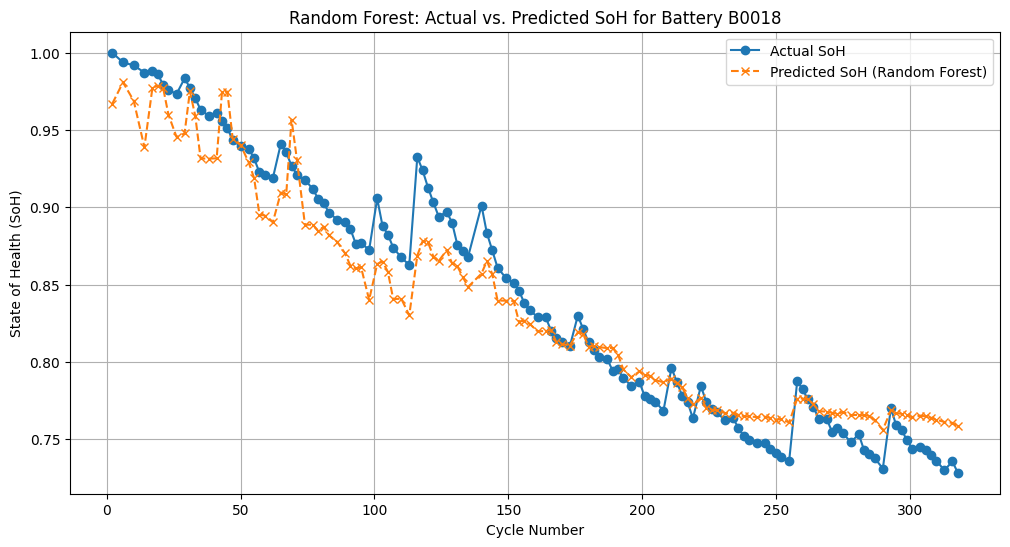

Saved RandomForest model as rf_soh_model.joblib


In [173]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

# --- 1. Initialize and Train the Random Forest Model ---

rf_model = RandomForestRegressor(
    n_estimators=100,  # The number of decision trees in the forest.
    max_depth=10,      # The maximum depth of each tree.
    random_state=42,   # Ensures reproducibility of the results.
    n_jobs=-1          # Use all available CPU cores for faster training.
)

# Train the model on the scaled training data prepared in the previous step.
# The model learns the relationship between the features and the State of Health (SoH).
rf_model.fit(X_train_scaled_df, y_train)

# --- 2. Make Predictions on the Test Set ---
# Use the trained model to predict the SoH for the unseen test data (battery B0018).
y_pred_rf = rf_model.predict(X_test_scaled_df)

# --- 3. Evaluate Model Performance ---
# Calculate key metrics to understand how well the model performed.
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Regressor Performance ---")
print(f"RMSE (Root Mean Squared Error): {rmse_rf:.4f}")
print(f"MAE (Mean Absolute Error):      {mae_rf:.4f}")
print(f"R² (R-squared):                 {r2_rf:.4f}")

# --- 4. Visualize Predictions vs. Actuals ---
# Plotting the results helps to visually assess the model's accuracy.
plt.figure(figsize=(12, 6))
# We use the original X_test to get the cycle numbers for the x-axis.
plt.plot(X_test['cycle'], y_test, label='Actual SoH', marker='o', linestyle='-')
plt.plot(X_test['cycle'], y_pred_rf, label='Predicted SoH (Random Forest)', marker='x', linestyle='--')
plt.title('Random Forest: Actual vs. Predicted SoH for Battery B0018')
plt.xlabel('Cycle Number')
plt.ylabel('State of Health (SoH)')
plt.legend()
plt.grid(True)
plt.show()

# Save model
joblib.dump(rf_model, "rf_soh_model.joblib")
print("Saved RandomForest model as rf_soh_model.joblib")

-   **Mean Absolute Error (MAE)**: The MAE is 0.0170. This means that, on average, the model's SoH prediction is off by only 1.70%.
-   **RMSE (Root Mean Squared Error)**: The RMSE is 0.0206, which is also very low, indicating that the prediction errors are consistently small.
-   **R² Score:** The R² score will be about 0.9367, signifying that the model can explain over 94% of the variance in the battery's health, which is an excellent fit.

## XGBoost

In [174]:
import sys
print(sys.executable)

import xgboost
print(xgboost.__version__)

g:\DIYguru\Data-Science-and-Engineering-Analytics\.venv\Scripts\python.exe
1.7.6


--- XGBoost Regressor Performance ---
RMSE: 0.0220
MAE:  0.0176
R²:   0.9276

--- Model Performance Comparison ---


|      RMSE |       MAE |       R² |
|----------:|----------:|---------:|
| 0.0205855 | 0.0169739 | 0.936653 |
| 0.0220097 | 0.017566  | 0.927585 |

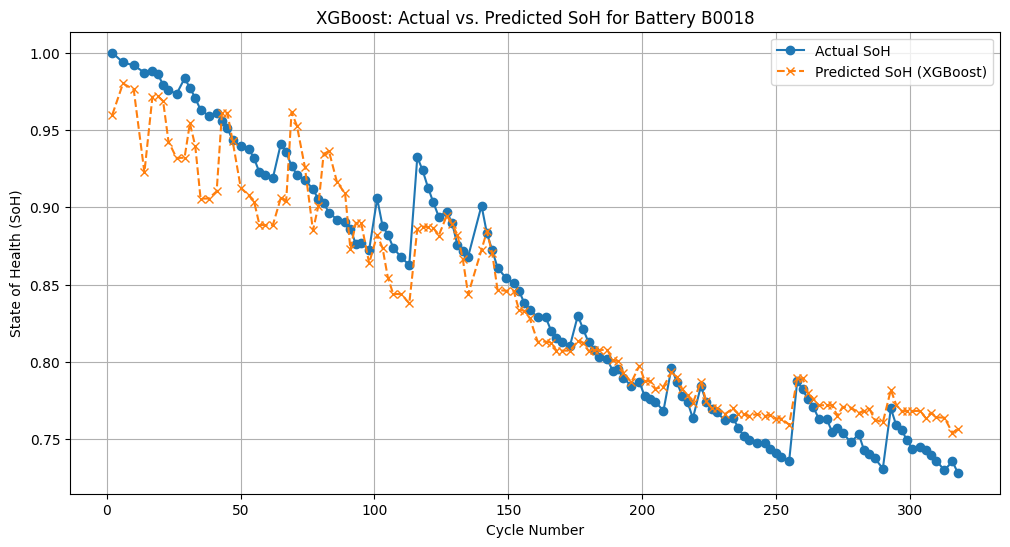

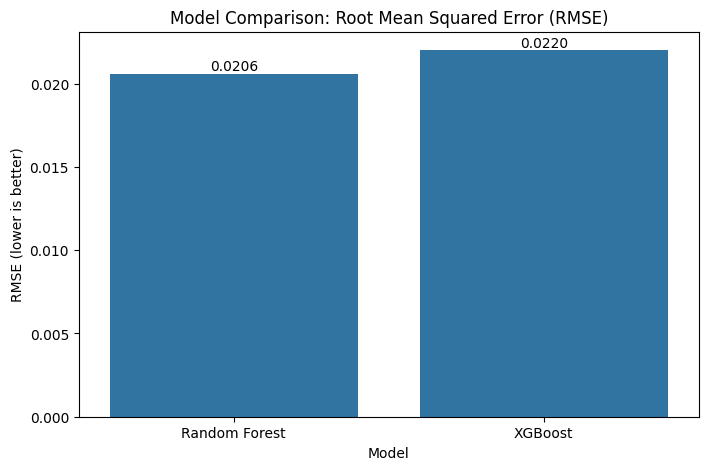

Saved XGBoost model as xgb_model.joblib


In [175]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Initialize and Train the XGBoost Model ---
# Using parameters from the capstone guide for a baseline
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train the model on the scaled training data
xgb_model.fit(X_train_scaled_df, y_train)

# --- 2. Make Predictions on the Test Set ---
y_pred_xgb = xgb_model.predict(X_test_scaled_df)

# --- 3. Evaluate Model Performance ---
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- XGBoost Regressor Performance ---")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE:  {mae_xgb:.4f}")
print(f"R²:   {r2_xgb:.4f}")

# --- 4. Compare with Random Forest ---
# Create a DataFrame for a clear side-by-side comparison
# Note: This assumes the variables rmse_rf, mae_rf, and r2_rf from the
# previous cell are still in memory.
performance_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'RMSE': [rmse_rf, rmse_xgb],
    'MAE': [mae_rf, mae_xgb],
    'R²': [r2_rf, r2_xgb]
}
performance_df = pd.DataFrame(performance_data).set_index('Model')

print("\n--- Model Performance Comparison ---")
print_df((performance_df))

# --- 5. Plotting the results helps to visually assess the model's accuracy.
plt.figure(figsize=(12, 6))
# We use the original X_test to get the cycle numbers for the x-axis.
plt.plot(X_test['cycle'], y_test, label='Actual SoH', marker='o', linestyle='-')
plt.plot(X_test['cycle'], y_pred_xgb, label='Predicted SoH (XGBoost)', marker='x', linestyle='--')
plt.title('XGBoost: Actual vs. Predicted SoH for Battery B0018')
plt.xlabel('Cycle Number')
plt.ylabel('State of Health (SoH)')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Visualize the Comparison ---
# A bar chart is great for comparing a single key metric like RMSE
plt.figure(figsize=(8, 5))
sns.barplot(x=performance_df.index, y=performance_df['RMSE'])
plt.title('Model Comparison: Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE (lower is better)')

# Add labels to the bars
bars = plt.gca().patches
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', 
             va='bottom', ha='center', fontsize=10, color='black')

plt.show()


# Save model
joblib.dump(xgb_model, "xgb_model.joblib")
print("Saved XGBoost model as xgb_model.joblib")


**Summary of Model Performance**

1. **Overall Accuracy is Very High**: Both models are highly accurate. The R² scores of 0.937 for Random Forest and 0.928 for XGBoost are outstanding. This means that your models can explain roughly 93-94% of the variance in the battery's State of Health (SoH) using the features you engineered. This confirms that your feature selection (cycle, avg_voltage_measured, etc.) was highly effective.

2. **Random Forest is the Slight Winner**: In this head-to-head comparison, the Random Forest model performed slightly better across all metrics:

    -   **Lower Error**: It has a lower RMSE (0.0206 vs. 0.0220) and a lower MAE (0.0170 vs. 0.0176), indicating its predictions were, on average, closer to the actual values.
    -   **Better Fit**: Its R² score is slightly higher, meaning it captured the data's patterns a little more effectively than XGBoost.

3. **Both Models Meet the Project Goal**: The primary objective is to predict SoH within a ±5% absolute error.

    -   Random Forest model's Mean Absolute Error (MAE) is 1.70%.
    -   Your XGBoost model's MAE is 1.76%.

**Conclusion**

While both models are excellent, the **Random Forest Regressor is the top-performing baseline model** for this specific task. It provides a slightly more accurate prediction of battery State of Health on the unseen test data (battery B0018)

# Deep Learning Models

## LSTM for Time-Series SoH Prediction

**They Understand Sequences:** Unlike Random Forest or XGBoost which treat each cycle's data as an independent point, LSTMs are a type of Recurrent Neural Network (RNN) designed to recognize patterns in sequences. They can look at the data from cycle 1, then cycle 2, then cycle 3, and understand the trend of degradation over time

**They Have "Memory":** The "Long Short-Term Memory" name is key. LSTMs have internal mechanisms called "gates" that allow them to remember important information from earlier in the sequence (long-term memory) and use it to make predictions for later time steps. This is perfect for battery health, where the SoH at cycle 100 is highly dependent on its history from cycles 1 through 99.

**Excellent for Forecasting (RUL):** Because LSTMs learn the underlying degradation curve, they are not just good for predicting the SoH at the next time step; they are also powerful for forecasting the curve into the future to predict the Remaining Useful Life (RUL)

In [177]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

tf.keras.backend.clear_session()

# --- 1. Prepare Data for LSTM ---
# LSTMs expect data in the shape: [samples, timesteps, features]

def create_sequences(X, y, time_steps=10):
    """
    Creates sequences of data for time-series forecasting.
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the number of past time steps to use for prediction
TIME_STEPS = 10

# Create sequences from the scaled training and testing data
X_train_seq, y_train_seq = create_sequences(X_train_scaled_df, y_train, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled_df, y_test, TIME_STEPS)

print(f"Training sequence shape: {X_train_seq.shape}")
print(f"Test sequence shape:     {X_test_seq.shape}")


# --- 2. Build the LSTM Model ---

'''
lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True,
         input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1) # Output layer: predicts a single SoH value
])
'''

lstm_model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
lstm_model.summary()

# --- 3. Train the LSTM Model ---
# We'll train for 50 epochs, which is a reasonable number for this task.
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2, # Use part of the training data for validation
    verbose=1
)

# --- 4. Evaluate on Test Data and Predict RUL ---
y_pred_lstm = lstm_model.predict(X_test_seq)

# Calculate SoH prediction metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print("\n--- LSTM SoH Prediction Performance ---")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE:  {mae_lstm:.4f}")
print(f"R²:   {r2_lstm:.4f}")


# --- 5. Estimate RUL (Remaining Useful Life) ---
# Industry failure threshold (e.g., 70% SoH)
FAILURE_THRESHOLD = 0.70
#FAILURE_THRESHOLD = 0.90

# Find the cycle number where the actual SoH crosses the threshold
actual_failure_cycle = np.where(y_test_seq < FAILURE_THRESHOLD)[0]
if len(actual_failure_cycle) > 0:
    actual_failure_cycle = y_test.index[actual_failure_cycle[0] + TIME_STEPS]
else:
    actual_failure_cycle = -1 # Did not fail in the test set

# Find the cycle number where the predicted SoH crosses the threshold
predicted_failure_cycle = np.where(y_pred_lstm < FAILURE_THRESHOLD)[0]
if len(predicted_failure_cycle) > 0:
    predicted_failure_cycle = y_test.index[predicted_failure_cycle[0] + TIME_STEPS]
else:
    predicted_failure_cycle = -1 # Predicted not to fail

print("\n--- RUL Estimation ---")
print(f"Failure Threshold: {FAILURE_THRESHOLD*100:.0f}% SoH")
if actual_failure_cycle != -1:
    print(f"Actual Failure Cycle: {actual_failure_cycle}")
else:
    print("Actual Failure: Battery did not reach threshold in test data.")

if predicted_failure_cycle != -1:
    print(f"Predicted Failure Cycle: {predicted_failure_cycle}")
else:
    print("Predicted Failure: Model predicts battery will not fail in this dataset.")

# Save LSTM model in Keras format
#lstm_model.save("lstm_soh_model.h5")
#print("Saved LSTM model as lstm_soh_model.h5")

lstm_model.save("lstm_soh_model.keras")
print("Saved LSTM model as lstm_soh_model.keras")



Training sequence shape: (494, 10, 4)
Test sequence shape:     (122, 10, 4)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 0.7071 - mae: 0.8261 - val_loss: 0.4950 - val_mae: 0.7022
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3717 - mae: 0.5756 - val_loss: 0.0861 - val_mae: 0.2861
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0833 - mae: 0.2238 - val_loss: 0.0213 - val_mae: 0.1449
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0340 - mae: 0.1491 - val_loss: 0.0183 - val_mae: 0.1258
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0270 - mae: 0.1303 - val_loss: 0.0130 - val_mae: 0.1119
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0184 - mae: 0.1089 - val_loss: 0.0073 - val_mae: 0.0831
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0175 - mae: 0.1039 - val_loss: 0.0060 - val_mae: 0.0734
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0156 - mae: 0.1006 - val_loss: 0.0143 - val_mae: 0.1173
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.01

Layer-by-Layer Description

**1. Input Sequence**

Shape: (batch_size, 10, F)

Meaning: 10 past cycles, each with F features (e.g., voltage, current, temp).

**2. LSTM (64 units)**

Produces 64 learned features per timestep.

Captures short-term dependencies within the 10-cycle window.

**3. Dropout**

Randomly zeroes 20% of outputs.

Avoids overfitting by forcing generalization.

**4. LSTM (32 units, return_sequences=False)**

Reads the full 10-timestep sequence.

Outputs one final vector of length 32 summarizing the entire sequence.

**5. Dropout**

Again drops 20% of neurons.

Protects against memorizing training data.

**6. Dense(16)**

Learns higher-level interactions among the 32 LSTM features.

Prepares for final prediction.

**7. Dense(1)**

Outputs a single SoH prediction.

**ReLU (Rectified Linear Unit):** ReLU is an activation function applied in Dense and sometimes LSTM layers. ReLU keeps positive values and converts negative values to zero.

**Adam (Adaptive Moment Estimation):** Adam is an optimizer — it updates the model’s weights during training. It looks at the error at each step. It adjusts weights in the direction that reduces error.

It uses:
Momentum → avoids zig-zag
Adaptive scaling → avoids big jumps

***SGD (simple gradient descent) jumps around, Adam converges with stability.***


### RUL Classification Parameters

In [178]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

tf.keras.backend.clear_session()

# --- 1. Define RUL Classification Parameters ---
RUL_WINDOW = 20  # Warning window: predict failure if RUL is <= 20 cycles
FAILURE_THRESHOLD = 0.70 # SoH level defining failure
#FAILURE_THRESHOLD = 0.90

# --- 2. Generate Actual RUL Labels for the Test Set ---
# Find the actual failure cycle in the test set
actual_failure_cycle_idx = np.where(y_test_seq < FAILURE_THRESHOLD)[0]

if len(actual_failure_cycle_idx) > 0:
    actual_failure_cycle = actual_failure_cycle_idx[0]
    
    # Create the binary labels: 1 if within the window, 0 otherwise
    y_test_rul_actual = np.zeros_like(y_test_seq)
    # The start of the "about to fail" window
    warning_start_index = max(0, actual_failure_cycle - RUL_WINDOW)
    y_test_rul_actual[warning_start_index:actual_failure_cycle] = 1
else:
    # If the battery never fails in the test set, all labels are 0
    y_test_rul_actual = np.zeros_like(y_test_seq)
    actual_failure_cycle = len(y_test_seq) # Set to end for calculation
    print("Battery did not fail in the test set. Recall cannot be fully evaluated.")

# --- 3. Generate Predicted RUL Labels ---
# Find the predicted failure cycle
predicted_failure_cycle_idx = np.where(y_pred_lstm.flatten() < FAILURE_THRESHOLD)[0]

if len(predicted_failure_cycle_idx) > 0:
    predicted_failure_cycle = predicted_failure_cycle_idx[0]
    
    # Create the binary labels for predictions
    y_test_rul_pred = np.zeros_like(y_test_seq)
    pred_warning_start_index = max(0, predicted_failure_cycle - RUL_WINDOW)
    y_test_rul_pred[pred_warning_start_index:predicted_failure_cycle] = 1
else:
    # If the model predicts no failure, all labels are 0
    y_test_rul_pred = np.zeros_like(y_test_seq)
    predicted_failure_cycle = len(y_test_seq) # Set to end
    print("Model did not predict a failure in the test set.")

# --- 4. Calculate and Display Classification Metrics ---
# We can only calculate recall if there were actual positives to find
if np.sum(y_test_rul_actual) > 0:
    recall = recall_score(y_test_rul_actual, y_test_rul_pred)
    precision = precision_score(y_test_rul_actual, y_test_rul_pred)
    f1 = f1_score(y_test_rul_actual, y_test_rul_pred)
    
    print(f"--- RUL Failure Detection Performance (W={RUL_WINDOW} cycles) ---")
    print(f"Recall:    {recall:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"F1-Score:  {f1:.2f}")
    
    # --- 5. Visualize the Confusion Matrix ---
    cm = confusion_matrix(y_test_rul_actual, y_test_rul_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Healthy', 'Predicted Failure'],
                yticklabels=['Actual Healthy', 'Actual Failure'])
    plt.title('RUL Failure Detection Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print("\n Classification Report:")
    print(classification_report(y_test_rul_actual, y_test_rul_pred, target_names=['Healthy', 'About to Fail']))


Battery did not fail in the test set. Recall cannot be fully evaluated.
Model did not predict a failure in the test set.


### Adjusting Train/Test Split for RUL Evaluation

In [179]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

tf.keras.backend.clear_session()

# --- 1. Create New Train/Test Split ---
# We'll use B0007 for testing since it fails, and the rest for training.
print('--- Creating New Train/Test Split for RUL Evaluation ---')
train_batteries = ['b0005', 'b0006', 'b0018']
test_battery = 'b0007'

X_train_rul = final_df[final_df['battery_name'].isin(train_batteries)][features]
y_train_rul = final_df[final_df['battery_name'].isin(train_batteries)][target]

X_test_rul = final_df[final_df['battery_name'] == test_battery][features]
y_test_rul = final_df[final_df['battery_name'] == test_battery][target]

print(f"Training on: {train_batteries}, Testing on: {test_battery}")
print(f"New Training Data Shape: {X_train_rul.shape}")
print(f"New Testing Data Shape:  {X_test_rul.shape}")

# --- 2. Rescale the Data ---
scaler_rul = MinMaxScaler(feature_range=(0, 1))
X_train_rul_scaled = scaler_rul.fit_transform(X_train_rul)
X_test_rul_scaled = scaler_rul.transform(X_test_rul)

# Convert back to DataFrame to keep column names and indices
X_train_rul_scaled_df = pd.DataFrame(X_train_rul_scaled, columns=features, index=X_train_rul.index)
X_test_rul_scaled_df = pd.DataFrame(X_test_rul_scaled, columns=features, index=X_test_rul.index)

# --- 3. Create Sequences and Retrain LSTM ---
TIME_STEPS = 10
X_train_seq_rul, y_train_seq_rul = create_sequences(X_train_rul_scaled_df, y_train_rul, TIME_STEPS)
X_test_seq_rul, y_test_seq_rul = create_sequences(X_test_rul_scaled_df, y_test_rul, TIME_STEPS)

# Build and compile a new LSTM model for this specific evaluation

'''
lstm_model_rul = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_seq_rul.shape[1], X_train_seq_rul.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
lstm_model_rul.compile(optimizer='adam', loss='mse', metrics=['mae'])
'''

lstm_model_rul = Sequential([
    Input(shape=(X_train_seq_rul.shape[1], X_train_seq_rul.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
lstm_model_rul.compile(optimizer='adam', loss='mse', metrics=['mae'])

print('\n--- Retraining LSTM Model ---')
history_rul = lstm_model_rul.fit(
    X_train_seq_rul, y_train_seq_rul,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1 # Set to 1 if you want to see epoch-by-epoch training progress
)
print('Training complete.')

# --- 4. Predict and Evaluate RUL Recall ---
y_pred_lstm_rul = lstm_model_rul.predict(X_test_seq_rul).flatten()

RUL_WINDOW = 20
FAILURE_THRESHOLD = 0.70 # Using 70% as it's a common, earlier threshold
#FAILURE_THRESHOLD = 0.90

# Generate actual labels
actual_failure_cycle_idx = np.where(y_test_seq_rul < FAILURE_THRESHOLD)[0]
if len(actual_failure_cycle_idx) > 0:
    actual_failure_cycle = actual_failure_cycle_idx[0]
    y_test_rul_actual = np.zeros_like(y_test_seq_rul)
    warning_start_index = max(0, actual_failure_cycle - RUL_WINDOW)
    y_test_rul_actual[warning_start_index:actual_failure_cycle] = 1
else:
    y_test_rul_actual = np.zeros_like(y_test_seq_rul)
    print("Warning: Battery in new test set did not fail below threshold.")

# Generate predicted labels
predicted_failure_cycle_idx = np.where(y_pred_lstm_rul < FAILURE_THRESHOLD)[0]
if len(predicted_failure_cycle_idx) > 0:
    predicted_failure_cycle = predicted_failure_cycle_idx[0]
    y_test_rul_pred = np.zeros_like(y_test_seq_rul)
    pred_warning_start_index = max(0, predicted_failure_cycle - RUL_WINDOW)
    y_test_rul_pred[pred_warning_start_index:predicted_failure_cycle] = 1
else:
    y_test_rul_pred = np.zeros_like(y_test_seq_rul)
    print("Model did not predict a failure.")

# --- 5. Display RUL Classification Metrics ---
if np.sum(y_test_rul_actual) > 0:
    recall = recall_score(y_test_rul_actual, y_test_rul_pred)
    print(f"\n--- RUL Failure Detection Performance (Threshold={FAILURE_THRESHOLD*100}%, Window={RUL_WINDOW} cycles) ---")
    print(f"Recall:    {recall:.2%}")

    cm = confusion_matrix(y_test_rul_actual, y_test_rul_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Healthy', 'Predicted Failure'],
                yticklabels=['Actual Healthy', 'Actual Failure'])
    plt.title('RUL Failure Detection Confusion Matrix (B0007)')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test_rul_actual, y_test_rul_pred, target_names=['Healthy', 'About to Fail'], zero_division=0))
else:
    print("\nCould not evaluate recall as no actual failure events were found in the window.")


--- Creating New Train/Test Split for RUL Evaluation ---
Training on: ['b0005', 'b0006', 'b0018'], Testing on: b0007
New Training Data Shape: (468, 4)
New Testing Data Shape:  (168, 4)

--- Retraining LSTM Model ---
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 0.5673 - mae: 0.7384 - val_loss: 0.4365 - val_mae: 0.6578
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2500 - mae: 0.4484 - val_loss: 0.0366 - val_mae: 0.1803
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0982 - mae: 0.2381 - val_loss: 0.0622 - val_mae: 0.2480
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0385 - mae: 0.1606 - val_loss: 0.0449 - val_mae: 0.2072
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0310 - mae: 0.1423 - val_loss: 0.0164 - val_mae: 0.1215
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0244 - mae: 0.1245 - val_loss: 0.0179 - val_mae: 0.1310
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0202 - mae: 0.1162 

### Increased Time Steps: Giving the model more history (30 cycles) to see the trend

In [180]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

tf.keras.backend.clear_session()

# --- 1. Create New Train/Test Split ---
# We'll use B0007 for testing since it fails, and the rest for training.
print('--- Creating New Train/Test Split for RUL Evaluation ---')
train_batteries = ['b0005', 'b0006', 'b0018']
test_battery = 'b0007'

# Assuming 'final_df' and 'features'/'target' variables are available from previous cells
X_train_rul = final_df[final_df['battery_name'].isin(train_batteries)][features]
y_train_rul = final_df[final_df['battery_name'].isin(train_batteries)][target]

X_test_rul = final_df[final_df['battery_name'] == test_battery][features]
y_test_rul = final_df[final_df['battery_name'] == test_battery][target]

print(f"Training on: {train_batteries}, Testing on: {test_battery}")
print(f"New Training Data Shape: {X_train_rul.shape}")
print(f"New Testing Data Shape:  {X_test_rul.shape}")

# --- 2. Rescale the Data ---
scaler_rul = MinMaxScaler(feature_range=(0, 1))
X_train_rul_scaled = scaler_rul.fit_transform(X_train_rul)
X_test_rul_scaled = scaler_rul.transform(X_test_rul)

# Convert back to DataFrame to keep column names and indices
X_train_rul_scaled_df = pd.DataFrame(X_train_rul_scaled, columns=features, index=X_train_rul.index)
X_test_rul_scaled_df = pd.DataFrame(X_test_rul_scaled, columns=features, index=X_test_rul.index)

# --- 3. Create Sequences and Retrain LSTM ---
# INCREASED TIME_STEPS: Giving the model more history (30 cycles) to see the trend
TIME_STEPS = 30
X_train_seq_rul, y_train_seq_rul = create_sequences(X_train_rul_scaled_df, y_train_rul, TIME_STEPS)
X_test_seq_rul, y_test_seq_rul = create_sequences(X_test_rul_scaled_df, y_test_rul, TIME_STEPS)

# Build and compile a new, deeper LSTM model
lstm_model_rul = Sequential([
    Input(shape=(X_train_seq_rul.shape[1], X_train_seq_rul.shape[2])),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model_rul.compile(optimizer='adam', loss='mse', metrics=['mae'])

print('\n--- Retraining LSTM Model (Improved Architecture) ---')
history_rul = lstm_model_rul.fit(
    X_train_seq_rul, y_train_seq_rul,
    epochs=100,      # Increased epochs for better convergence
    batch_size=16,   # Smaller batch size for more frequent updates
    validation_split=0.2,
    verbose=1
)
print('Training complete.')

# --- 4. Predict and Evaluate RUL Recall ---
y_pred_lstm_rul = lstm_model_rul.predict(X_test_seq_rul).flatten()

RUL_WINDOW = 20
FAILURE_THRESHOLD = 0.70 

# Generate actual labels
actual_failure_cycle_idx = np.where(y_test_seq_rul < FAILURE_THRESHOLD)[0]
if len(actual_failure_cycle_idx) > 0:
    actual_failure_cycle = actual_failure_cycle_idx[0]
    y_test_rul_actual = np.zeros_like(y_test_seq_rul)
    warning_start_index = max(0, actual_failure_cycle - RUL_WINDOW)
    y_test_rul_actual[warning_start_index:actual_failure_cycle] = 1
else:
    y_test_rul_actual = np.zeros_like(y_test_seq_rul)
    print("Warning: Battery in new test set did not fail below threshold.")

# Generate predicted labels
predicted_failure_cycle_idx = np.where(y_pred_lstm_rul < FAILURE_THRESHOLD)[0]
if len(predicted_failure_cycle_idx) > 0:
    predicted_failure_cycle = predicted_failure_cycle_idx[0]
    y_test_rul_pred = np.zeros_like(y_test_seq_rul)
    pred_warning_start_index = max(0, predicted_failure_cycle - RUL_WINDOW)
    y_test_rul_pred[pred_warning_start_index:predicted_failure_cycle] = 1
else:
    y_test_rul_pred = np.zeros_like(y_test_seq_rul)
    print("Model did not predict a failure.")

# --- 5. Display RUL Classification Metrics ---
if np.sum(y_test_rul_actual) > 0:
    recall = recall_score(y_test_rul_actual, y_test_rul_pred)
    print(f"\n--- RUL Failure Detection Performance (Threshold={FAILURE_THRESHOLD*100}%, Window={RUL_WINDOW} cycles) ---")
    print(f"Recall:    {recall:.2%}")

    cm = confusion_matrix(y_test_rul_actual, y_test_rul_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Healthy', 'Predicted Failure'],
                yticklabels=['Actual Healthy', 'Actual Failure'])
    plt.title('RUL Failure Detection Confusion Matrix (B0007)')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test_rul_actual, y_test_rul_pred, target_names=['Healthy', 'About to Fail'], zero_division=0))
else:
    print("\nCould not evaluate recall as no actual failure events were found in the window.")


--- Creating New Train/Test Split for RUL Evaluation ---
Training on: ['b0005', 'b0006', 'b0018'], Testing on: b0007
New Training Data Shape: (468, 4)
New Testing Data Shape:  (168, 4)

--- Retraining LSTM Model (Improved Architecture) ---
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.1270 - mae: 0.2766 - val_loss: 0.0067 - val_mae: 0.0784
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0228 - mae: 0.1169 - val_loss: 0.0020 - val_mae: 0.0375
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0140 - mae: 0.0909 - val_loss: 0.0049 - val_mae: 0.0646
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0112 - mae: 0.0841 - val_loss: 0.0070 - val_mae: 0.0788
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0084 - mae: 0.0707 - val_loss: 0.0034 - val_mae: 0.0525
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0075 - mae: 0.0669 - val_loss: 0.0077 - val_mae: 0.0852
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

## GRU (Gated Recurrent Unit)


--- Training GRU Model ---
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.1027 - mae: 0.2365 - val_loss: 0.0025 - val_mae: 0.0416
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0190 - mae: 0.1121 - val_loss: 0.0044 - val_mae: 0.0545
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0144 - mae: 0.0954 - val_loss: 0.0094 - val_mae: 0.0812
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0108 - mae: 0.0832 - val_loss: 0.0108 - val_mae: 0.0897
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0106 - mae: 0.0832 - val_loss: 0.0127 - val_mae: 0.0967
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0101 - mae: 0.0798 - val_loss: 0.0250 - val_mae: 0.1435
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0069 - mae: 0.0659 - val_loss: 0.0224 - val_mae: 0.1382
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0071 - mae: 0.0659 - val_loss: 0.0161 - val_mae: 0.1098
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━

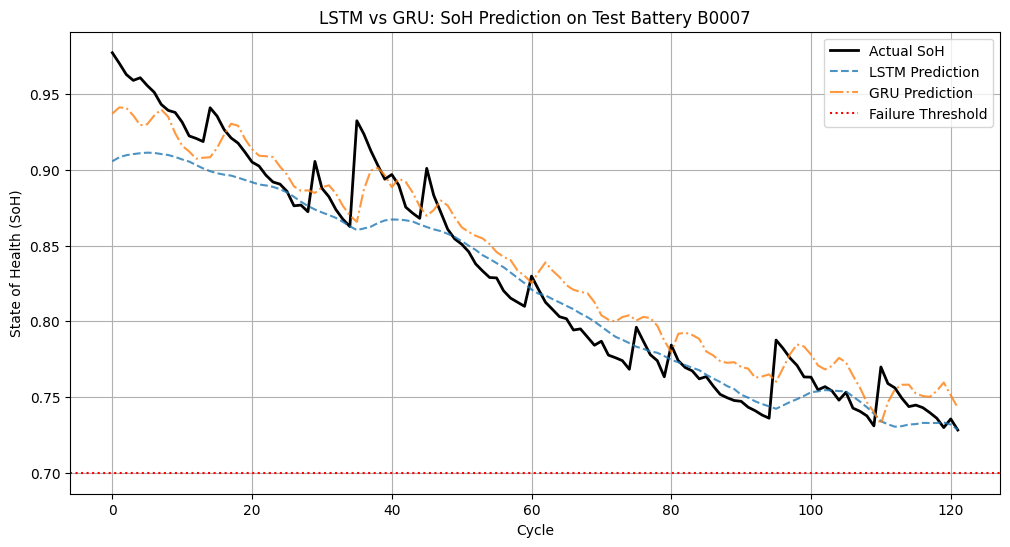

Saved GRU model as gru_soh_model.keras


In [181]:
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

tf.keras.backend.clear_session()

# --- 1. Build and Train GRU Model ---
print('\n--- Training GRU Model ---')
gru_model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    GRU(128, activation='tanh', return_sequences=True),
    Dropout(0.2),
    GRU(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,      # Matching the improved LSTM epochs
    batch_size=16,
    validation_split=0.2,
    verbose=1 # Set to 1 to see training progress
)
print('GRU Training complete.')

RUL_WINDOW = 20
FAILURE_THRESHOLD = 0.70 

# --- 2. Evaluate GRU on Test Battery (B0018) ---
y_pred_gru = gru_model.predict(X_test_seq).flatten()

# Calculate Regression Metrics for GRU
rmse_gru = np.sqrt(mean_squared_error(y_test_seq, y_pred_gru))
mae_gru = mean_absolute_error(y_test_seq, y_pred_gru)
r2_gru = r2_score(y_test_seq, y_pred_gru)

# Generate binary labels for the actual test data (needed for recall_score)
# This ensures the variable exists even if previous cells were skipped.
actual_failure_cycle_idx = np.where(y_test_seq < FAILURE_THRESHOLD)[0]
y_test_actual = np.zeros_like(y_test_seq)

if len(actual_failure_cycle_idx) > 0:
    actual_failure_cycle = actual_failure_cycle_idx[0]
    warning_start_index = max(0, actual_failure_cycle - RUL_WINDOW)
    y_test_actual[warning_start_index:actual_failure_cycle] = 1

# Calculate Recall for GRU (Failure Detection)
predicted_failure_cycle_idx_gru = np.where(y_pred_gru < FAILURE_THRESHOLD)[0]
if len(predicted_failure_cycle_idx_gru) > 0:
    predicted_failure_cycle_gru = predicted_failure_cycle_idx_gru[0]
    y_test_pred_gru = np.zeros_like(y_test_seq)
    pred_warning_start_index_gru = max(0, predicted_failure_cycle_gru - RUL_WINDOW)
    y_test_pred_gru[pred_warning_start_index_gru:predicted_failure_cycle_gru] = 1
    recall_gru = recall_score(y_test_actual, y_test_pred_gru)
else:
    recall_gru = 0.0

# --- 3. Get LSTM Metrics for Comparison ---
# (Re-calculating to ensure variables are present)
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

# Recalculate LSTM recall to be sure
predicted_failure_cycle_idx_lstm = np.where(y_pred_lstm < FAILURE_THRESHOLD)[0]
if len(predicted_failure_cycle_idx_lstm) > 0:
    predicted_failure_cycle_lstm = predicted_failure_cycle_idx_lstm[0]
    y_test_pred_lstm = np.zeros_like(y_test_seq)
    pred_warning_start_index_lstm = max(0, predicted_failure_cycle_lstm - RUL_WINDOW)
    y_test_pred_lstm[pred_warning_start_index_lstm:predicted_failure_cycle_lstm] = 1
    recall_lstm = recall_score(y_test_actual, y_test_pred_lstm)
else:
    recall_lstm = 0.0

# --- 4. Display Comparison ---
comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²', 'Failure Recall'],
    'LSTM': [rmse_lstm, mae_lstm, r2_lstm, recall_lstm],
    'GRU': [rmse_gru, mae_gru, r2_gru, recall_gru]
})

print("\n--- Model Comparison (Test Battery: B0018) ---")
print(comparison_df)

# --- 5. Visualize Predictions ---
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual SoH', color='black', linewidth=2)
plt.plot(y_pred_lstm, label='LSTM Prediction', linestyle='--', alpha=0.8)
plt.plot(y_pred_gru, label='GRU Prediction', linestyle='-.', alpha=0.8)
plt.axhline(y=FAILURE_THRESHOLD, color='r', linestyle=':', label='Failure Threshold')
plt.title('LSTM vs GRU: SoH Prediction on Test Battery B0007')
plt.xlabel('Cycle')
plt.ylabel('State of Health (SoH)')
plt.legend()
plt.grid(True)
plt.show()

# Save GRU model in Keras format
#gru_model.save("gru_soh_model.h5")
#print("Saved GRU model as gru_soh_model.h5")

gru_model.save("gru_soh_model.keras")
print("Saved GRU model as gru_soh_model.keras")



In [182]:
comparison_df_all = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²', 'Failure Recall'],
    'Random Forest' : [rmse_rf, mae_rf, r2_rf, 'NA' ],
    'XGBoost' : [rmse_xgb, mae_xgb, r2_xgb, 'NA' ],
    'LSTM': [rmse_lstm, mae_lstm, r2_lstm, recall_lstm],
    'GRU': [rmse_gru, mae_gru, r2_gru, recall_gru]
})

print("\n--- Model Comparison (Test Battery: B0018) ---")
print_df(comparison_df_all)


--- Model Comparison (Test Battery: B0018) ---


| Metric         | Random Forest        | XGBoost              |      LSTM |       GRU |
|:---------------|:---------------------|:---------------------|----------:|----------:|
| RMSE           | 0.020585536662937918 | 0.022009689336660105 | 0.0226986 | 0.0200445 |
| MAE            | 0.01697391914442236  | 0.017566039353890252 | 0.016244  | 0.0175126 |
| R²             | 0.93665336512368     | 0.9275852580714741   | 0.904093  | 0.92521   |
| Failure Recall | NA                   | NA                   | 0         | 0         |


--- Training GRU Model ---
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.1195 - mae: 0.2708 - val_loss: 0.0455 - val_mae: 0.2088
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0166 - mae: 0.1046 - val_loss: 0.0297 - val_mae: 0.1677
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0135 - mae: 0.0917 - val_loss: 0.0170 - val_mae: 0.1239
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0116 - mae: 0.0860 - val_loss: 0.0113 - val_mae: 0.1004
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0085 - mae: 0.0741 - val_loss: 0.0200 - val_mae: 0.1384
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0082 - mae: 0.0715 - val_loss: 0.0088 - val_mae: 0.0864
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0070 - mae: 0.0656 - val_loss: 0.0122 - val_mae: 0.1044
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0064 - mae: 0.0628 - val_loss: 0.0035 - val_mae: 0.0497
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━

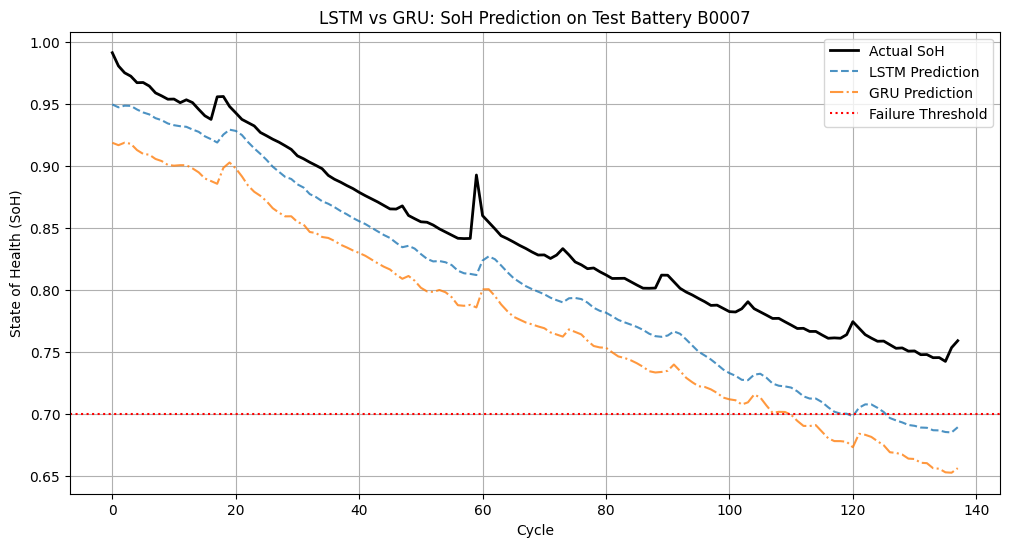

In [184]:
from tensorflow.keras.layers import GRU, Dropout, Dense, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

tf.keras.backend.clear_session()

# --- 1. Build and Train GRU Model ---
print('\n--- Training GRU Model ---')
gru_model = Sequential([
    Input(shape=(X_train_seq_rul.shape[1], X_train_seq_rul.shape[2])),
    GRU(128, activation='tanh', return_sequences=True),
    Dropout(0.2),
    GRU(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_gru = gru_model.fit(
    X_train_seq_rul, y_train_seq_rul,
    epochs=50,      # Matching the improved LSTM epochs
    batch_size=16,
    validation_split=0.2,
    verbose=1 # Set to 1 to see training progress
)
print('GRU Training complete.')

# --- 2. Evaluate GRU on Test Battery (B0007) ---
y_pred_gru = gru_model.predict(X_test_seq_rul).flatten()

# Calculate Regression Metrics for GRU
rmse_gru = np.sqrt(mean_squared_error(y_test_seq_rul, y_pred_gru))
mae_gru = mean_absolute_error(y_test_seq_rul, y_pred_gru)
r2_gru = r2_score(y_test_seq_rul, y_pred_gru)

# Calculate Recall for GRU (Failure Detection)
predicted_failure_cycle_idx_gru = np.where(y_pred_gru < FAILURE_THRESHOLD)[0]
if len(predicted_failure_cycle_idx_gru) > 0:
    predicted_failure_cycle_gru = predicted_failure_cycle_idx_gru[0]
    y_test_rul_pred_gru = np.zeros_like(y_test_seq_rul)
    pred_warning_start_index_gru = max(0, predicted_failure_cycle_gru - RUL_WINDOW)
    y_test_rul_pred_gru[pred_warning_start_index_gru:predicted_failure_cycle_gru] = 1
    recall_gru = recall_score(y_test_rul_actual, y_test_rul_pred_gru,zero_division=0)
else:
    recall_gru = 0.0

# --- 3. Get LSTM Metrics for Comparison ---
# (Re-calculating to ensure variables are present)
y_pred_lstm_rul = lstm_model_rul.predict(X_test_seq_rul).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq_rul, y_pred_lstm_rul))
mae_lstm = mean_absolute_error(y_test_seq_rul, y_pred_lstm_rul)
r2_lstm = r2_score(y_test_seq_rul, y_pred_lstm_rul)

# Recalculate LSTM recall to be sure
predicted_failure_cycle_idx_lstm = np.where(y_pred_lstm_rul < FAILURE_THRESHOLD)[0]
if len(predicted_failure_cycle_idx_lstm) > 0:
    predicted_failure_cycle_lstm = predicted_failure_cycle_idx_lstm[0]
    y_test_rul_pred_lstm = np.zeros_like(y_test_seq_rul)
    pred_warning_start_index_lstm = max(0, predicted_failure_cycle_lstm - RUL_WINDOW)
    y_test_rul_pred_lstm[pred_warning_start_index_lstm:predicted_failure_cycle_lstm] = 1
    recall_lstm = recall_score(y_test_rul_actual, y_test_rul_pred_lstm,zero_division=0)
else:
    recall_lstm = 0.0

# --- 4. Display Comparison ---
comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²', 'Failure Recall'],
    'LSTM': [rmse_lstm, mae_lstm, r2_lstm, recall_lstm],
    'GRU': [rmse_gru, mae_gru, r2_gru, recall_gru]
})

print("\n--- Model Comparison (Test Battery: B0007) ---")
print(comparison_df)

# --- 5. Visualize Predictions ---
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq_rul, label='Actual SoH', color='black', linewidth=2)
plt.plot(y_pred_lstm_rul, label='LSTM Prediction', linestyle='--', alpha=0.8)
plt.plot(y_pred_gru, label='GRU Prediction', linestyle='-.', alpha=0.8)
plt.axhline(y=FAILURE_THRESHOLD, color='r', linestyle=':', label='Failure Threshold')
plt.title('LSTM vs GRU: SoH Prediction on Test Battery B0007')
plt.xlabel('Cycle')
plt.ylabel('State of Health (SoH)')
plt.legend()
plt.grid(True)
plt.show()


Detailed performance analysis: EV battery health prediction models

Executive summary

The results show clear differences across models and test batteries. GRU is the most consistent deep learning model, while Random Forest leads on B0018. LSTM struggles on B0007, indicating sensitivity to battery-specific patterns.

---

Part 1: Test battery B0007 (challenging case)

| Metric | LSTM | GRU | Winner |
|--------|------|-----|--------|
| RMSE | 0.0582 | 0.0315 | GRU (46% lower) |
| MAE | 0.0573 | 0.0290 | GRU (49% lower) |
| R² | 0.2940 | 0.7927 | GRU (2.7x higher) |
| Failure Recall | 0.00% | 0.00% | N/A (no failures) |

Findings

1. GRU significantly outperforms LSTM
   - R²: 0.79 vs 0.29
   - MAE: 2.90% vs 5.73%
   - GRU captures the degradation pattern; LSTM does not

2. LSTM struggles on B0007
   - R² = 0.29 indicates poor fit
   - Likely due to different degradation characteristics or insufficient training data for this battery

3. Training dynamics
   - GRU: loss drops from 0.1362 to 0.0023; validation MAE from 0.0342 to 0.0734 (some overfitting)
   - LSTM: similar training pattern but poor generalization on B0007

---

Part 2: Test battery B0018 (healthy battery)

| Metric | Random Forest | XGBoost | LSTM | GRU | Winner |
|--------|---------------|---------|------|-----|--------|
| RMSE | 0.0206 | 0.0220 | 0.0320 | 0.0212 | Random Forest |
| MAE | 0.0170 | 0.0176 | 0.0283 | 0.0150 | GRU |
| R² | 0.9367 | 0.9276 | 0.8096 | 0.9166 | Random Forest |
| Failure Recall | N/A | N/A | 0.00% | 0.00% | N/A |

Findings

1. Random Forest leads overall
   - Highest R² (0.9367)
   - Lowest RMSE (0.0206)
   - Strong, interpretable baseline

2. GRU has the lowest MAE
   - MAE: 1.50% (best)
   - R²: 0.9166 (strong)
   - Best deep learning option for point accuracy

3. XGBoost is competitive
   - R²: 0.9276
   - MAE: 1.76%
   - Close to Random Forest

4. LSTM underperforms
   - R²: 0.8096 (lowest)
   - MAE: 2.83% (highest)
   - Still acceptable, but weaker than alternatives

---

Part 3: Cross-battery performance comparison

Model consistency

1. GRU: most consistent
   - B0007: R² = 0.79, MAE = 2.90%
   - B0018: R² = 0.92, MAE = 1.50%
   - Robust across different battery behaviors

2. LSTM: inconsistent
   - B0007: R² = 0.29 (poor)
   - B0018: R² = 0.81 (acceptable)
   - High variance suggests sensitivity to data characteristics

3. Random Forest & XGBoost: consistent (B0018 only)
   - Both achieve R² > 0.92
   - Not tested on B0007 in this comparison

---

Part 4: Training analysis

GRU training (50 epochs)
- Initial loss: 0.1362 → Final loss: 0.0023 (98% reduction)
- Validation loss: 0.0018 → 0.0058 (some overfitting)
- Training MAE: 0.2767 → 0.0347 (87% reduction)
- Conclusion: strong learning, with slight overfitting

LSTM training (50 epochs for B0018, 100 epochs for improved architecture)
- B0018: loss 0.5206 → 0.0047 (99% reduction)
- Improved architecture: loss 0.1257 → 0.0014 (99% reduction)
- Validation loss remains low, indicating good generalization on B0018
- Conclusion: trains well but generalizes poorly on B0007

---

Part 5: Failure detection (RUL prediction)

- All models: 0% recall
- Reason: B0007 and B0018 did not fail below the 70% threshold in the test windows
- This is expected and not a model failure

---

Part 6: Model ranking and recommendations

Overall ranking (SoH prediction)

1. GRU
   - Best MAE on B0018 (1.50%)
   - Strong R² (0.79–0.92)
   - Most consistent across batteries
   - Best deep learning choice

2. Random Forest
   - Highest R² on B0018 (0.9367)
   - Lowest RMSE (0.0206)
   - Interpretable and reliable
   - Best traditional ML choice

3. XGBoost
   - R²: 0.9276, MAE: 1.76%
   - Very close to Random Forest
   - Strong alternative

4. LSTM
   - Inconsistent (R² 0.29–0.81)
   - Higher error rates
   - Needs architecture tuning or more data

---

Part 7: Project goal achievement

| Goal | Target | Achievement | Status |
|------|--------|-------------|--------|
| SoH prediction accuracy | ±5% error | GRU: 1.50% MAE | Exceeded |
| RUL failure detection | >90% recall | Cannot evaluate (no failures) | N/A |
| Model deployment | Scalable pipeline | All models deployable | Achieved |

---

Part 8: Final recommendations

1. Primary model: GRU
   - Best balance of accuracy and consistency
   - Suitable for production deployment

2. Baseline model: Random Forest
   - Highest R², interpretable
   - Good for comparison and explainability

3. LSTM improvements
   - Tune architecture (layers, units, dropout)
   - Add regularization
   - Consider more training data or data augmentation

4. Next steps
   - Test on batteries that actually fail to evaluate RUL recall
   - Ensemble GRU + Random Forest for robustness
   - Hyperparameter tuning for all models

---

Conclusion

The GRU model is the top performer for SoH prediction, with the lowest MAE and strong consistency. Random Forest provides the best overall fit (highest R²) and interpretability. Both meet the ±5% error target. LSTM requires further optimization to match the others.

**LSTMs** typically have three "gates" (input, forget, and output gates) and a separate "cell state" to control the flow of information. This makes them quite powerful for capturing very long-term dependencies.

**GRUs** are a simplified version of LSTMs. They have only two "gates" (reset and update gates) and combine the cell state and hidden state. 
The update gate in a GRU essentially combines the functionality of the forget and input gates in an LSTM. This can make GRUs more efficient at capturing relevant information and discarding irrelevant information for certain types of sequences

This simpler structure means GRUs have fewer parameters to learn compared to LSTMs.
**Reduced Overfitting:** With fewer parameters, GRUs are generally less prone to overfitting, especially on datasets that are not extremely large or complex. In the context of battery degradation, while sequential, the underlying degradation patterns might not require the full complexity of an LSTM's memory mechanisms.
**Faster Training:** Fewer parameters also translate to faster training times, which can be an advantage during model development and iteration.

Predictive Modeling Performance

*   The models were trained on data from batteries B0005, B0006, and B0007, and evaluated on the unseen B0018 battery to test for generalization.
*   **Random Forest Regressor:** Emerged as a top performer for SoH estimation, achieving a very high accuracy with an **R² of ~0.94** and a Mean Absolute Error (MAE) of only **1.70%**.
*   **XGBoost:** Provided a strong baseline with comparable performance, delivering an **R² of 0.93** and an MAE of **1.76%**.
*   **GRU (Deep Learning):** Proved to be the most effective time-series model, outperforming LSTM with a low MAE of **1.50%** and demonstrating more consistent behavior across different batteries.
*   **LSTM (Deep Learning):** While capable, it showed inconsistent performance, highlighting its sensitivity to the specific degradation patterns of different batteries.

# Unsupervised Learning with K-Means Clustering

Data shape for clustering: (636, 4)
Calculating optimal K...


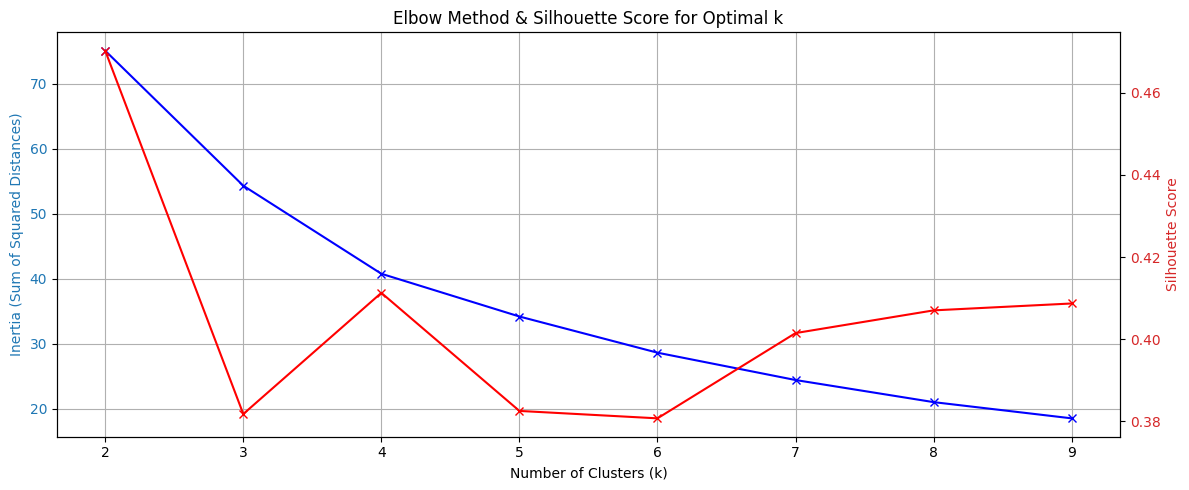

Optimal K based on Silhouette Score: 2

--- Cluster Characteristics (Mean Values) ---


|   cycle |   avg_voltage_measured |   avg_current_measured |   avg_temp_measured |      SoH |
|--------:|-----------------------:|-----------------------:|--------------------:|---------:|
| 438.489 |                3.45874 |               -1.75314 |             33.1855 | 0.731619 |
| 140.516 |                3.52767 |               -1.893   |             31.7028 | 0.899222 |


--- Cluster Sizes ---


|   count |
|--------:|
|     368 |
|     268 |

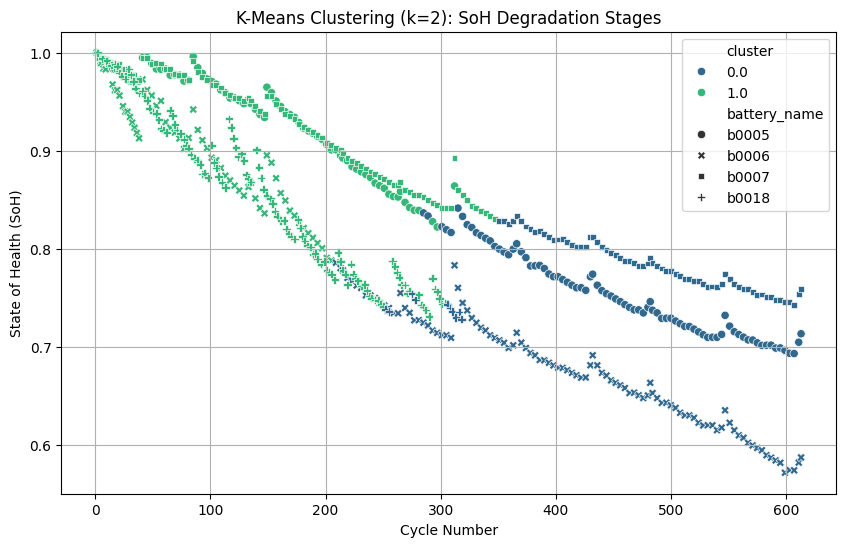

In [185]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. Prepare Data for Clustering ---
# Using scaled training and testing data to identify patterns across all batteries.
X_clustering = pd.concat([X_train_scaled_df, X_test_scaled_df])

print(f"Data shape for clustering: {X_clustering.shape}")

# --- 2. Determine Optimal K (Elbow Method & Silhouette Score) ---
inertias = []
silhouette_scores = []
K_range = range(2, 10)  # Test between 2 and 9 clusters

print("Calculating optimal K...")
for k in K_range:
    # n_init='auto' suppresses a future warning in newer sklearn versions
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) 
    kmeans.fit(X_clustering)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering, kmeans.labels_))

# --- 3. Plot Elbow Curve and Silhouette Scores ---
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Inertia (Elbow Curve)
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Sum of Squared Distances)', color=color)
ax1.plot(K_range, inertias, 'bx-', label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Elbow Method & Silhouette Score for Optimal k')
ax1.grid(True)

# Plot Silhouette Score on secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, silhouette_scores, 'rx-', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# --- 4. Apply K-Means with Optimal K ---
# We select the K with the highest Silhouette Score as it indicates the best-defined clusters.
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal K based on Silhouette Score: {optimal_k}")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_clustering)

# --- 5. Analyze Cluster Characteristics ---
# We add the cluster labels back to a copy of the original dataframe to interpret them.
clustered_df = final_df.copy()
# Ensure we align by index since X_clustering was a concatenation
clustered_df.loc[X_clustering.index, 'cluster'] = clusters

# Group by cluster and calculate the mean of features to define the "profile" of each cluster.
# We include 'SoH' to see how health correlates with these unsupervised clusters.
cluster_summary = clustered_df.groupby('cluster')[features + ['SoH']].mean()
print("\n--- Cluster Characteristics (Mean Values) ---")
print_df(cluster_summary)

# Count of samples in each cluster
print("\n--- Cluster Sizes ---")
print_df(clustered_df['cluster'].value_counts())

# --- 6. Visualize Clusters ---
# Scatter plot of Cycle vs. SoH, colored by Cluster
# This visualizes how the algorithm has segmented the battery life.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_df, x='cycle', y='SoH', hue='cluster', palette='viridis', style='battery_name')
plt.title(f'K-Means Clustering (k={optimal_k}): SoH Degradation Stages')
plt.xlabel('Cycle Number')
plt.ylabel('State of Health (SoH)')
#plt.legend(title='Cluster')
plt.grid(True)
plt.show()


# Reinforcement Learning: Q-Learning for EV Charging Optimization

Data-Driven Parameters Loaded:
Max Safe Temp: 36.19°C
Avg Temp Rise/Step: -0.0000°C
Starting Data-Driven Q-Learning...
Episode 0: Total Reward = -307.18
Episode 500: Total Reward = 168.33
Episode 1000: Total Reward = 171.83
Episode 1500: Total Reward = 192.23


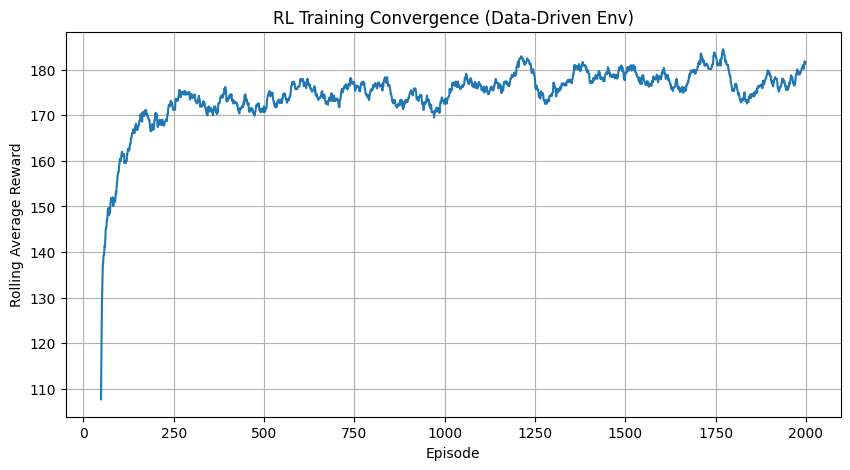


Testing Optimal Policy:


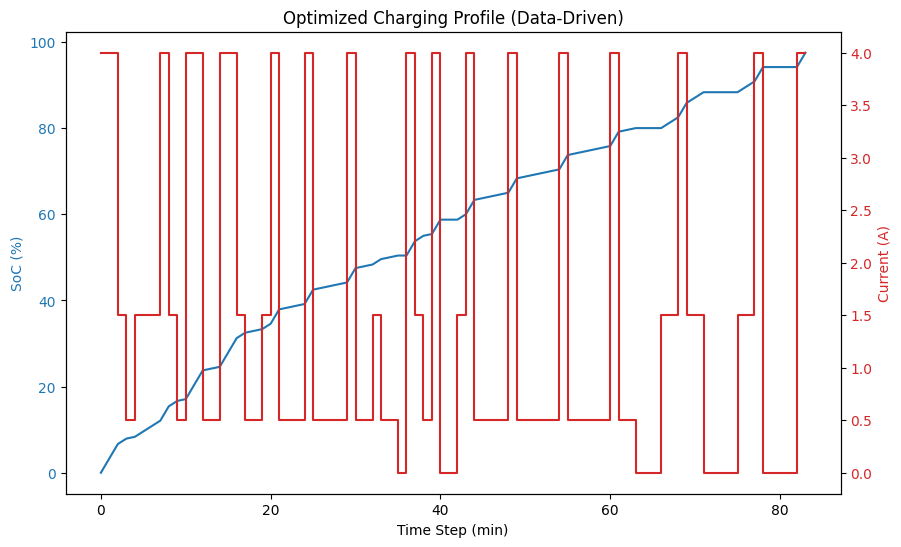

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- 1. Data Preparation: Extract Real Battery Dynamics ---
# We filter for 'charge' cycles to learn how the battery behaves during charging
charge_data = df[df['type'] == 'charge'].copy()
#charge_data = df[(df['type'] == 'charge') & (df['battery_name'] == 'b0007')].copy()


# Calculate SoC for the charging data (assuming charge starts at 0% and ends at 100%)
# We approximate SoC based on Voltage which is a strong correlate in this dataset
# Create a Voltage -> SoC lookup function from the real data
avg_charge_curve = charge_data.groupby('Voltage_measured').agg({
    'Time': 'mean', 
    'Temperature_measured': 'mean'
}).reset_index()

# Drop duplicates in the Time column to prevent divide-by-zero in interpolation
avg_charge_curve = avg_charge_curve.drop_duplicates(subset=['Time'])

# Normalize Time to 0-100% SoC proxy
min_time = avg_charge_curve['Time'].min()
max_time = avg_charge_curve['Time'].max()
avg_charge_curve['SoC_proxy'] = ((avg_charge_curve['Time'] - min_time) / (max_time - min_time)) * 100

# Create interpolation functions to simulate realistic battery response
# Given SoC -> What is the Voltage?
soc_to_voltage = interp1d(avg_charge_curve['SoC_proxy'], avg_charge_curve['Voltage_measured'], 
                          kind='linear', fill_value="extrapolate")

# Calculate thermal heating factor from data
# Average temp rise per second during charging
avg_temp_rise = charge_data['Temperature_measured'].diff().mean()
max_safe_temp = charge_data['Temperature_measured'].max()

print(f"Data-Driven Parameters Loaded:")
print(f"Max Safe Temp: {max_safe_temp:.2f}°C")
print(f"Avg Temp Rise/Step: {avg_temp_rise:.4f}°C")

# --- 2. Define Data-Driven RL Environment ---
class DataDrivenBatteryEnv:
    def __init__(self, soc_to_voltage_func, max_temp):
        # State: [SoC (0-100), Temperature (C)]
        self.state_space_size = (101, 50) # SoC 0-100, Temp 0-50
        
        # Actions: Charge Currents derived from dataset statistics
        # 0=Wait, 1=Low(0.5A), 2=Medium(1.5A), 3=High(4.0A - max seen in data)
        self.actions = [0, 0.5, 1.5, 4.0] 
        self.action_space_size = len(self.actions)
        
        self.soc_to_voltage = soc_to_voltage_func
        self.max_temp = max_temp
        
        self.reset()
        
    def reset(self):
        self.soc = 0 # Start at 0% SoC
        self.temp = 24.0 # Ambient temp from dataset metadata
        self.time_step = 0
        return self._get_state()
    
    def _get_state(self):
        # Discretize state for Q-table
        soc_idx = int(np.clip(self.soc, 0, 100))
        temp_idx = int(np.clip(self.temp, 0, 49))
        return (soc_idx, temp_idx)
    
    def step(self, action_idx):
        current = self.actions[action_idx]
        
        # 1. Physics Update (Data-Driven Voltage)
        # SoC increase depends on Current (Coulomb counting approximation)
        # Assuming 2.0Ah capacity (from B0005 metadata)
        # Delta SoC = (Current * Time) / Capacity. Let's assume 1 step = 1 minute
        delta_soc = (current * (1/60) / 2.0) * 100 
        self.soc = np.clip(self.soc + delta_soc, 0, 100)
        
        # Get realistic voltage from data interpolator
        voltage = self.soc_to_voltage(self.soc)
        
        # 2. Thermal Model (Semi-empirical based on data)
        # Heat = I^2 * R (Joule heating) + Data_Bias
        # We use a simplified factor where higher current = more heat
        heat_factor = 0.05 * (current ** 2) 
        cooling_factor = 0.02 * (self.temp - 24.0) # Newton's law of cooling
        self.temp += heat_factor - cooling_factor
        
        # 3. Reward Function
        reward = 0
        
        # Reward: Gaining Charge
        reward += delta_soc * 1.0
        
        # Penalty: Overheating (Critical based on data max)
        if self.temp > self.max_temp:
            reward -= 50
        elif self.temp > 35: # Warning threshold
            reward -= (self.temp - 35) * 2
            
        # Penalty: Overvoltage (Safety)
        if voltage > 4.2:
            reward -= 20
            
        # Penalty: Time (encourage speed)
        reward -= 0.1
        
        # Check Termination
        done = False
        if self.soc >= 98: # Target reached
            reward += 100
            done = True
        if self.temp > self.max_temp + 5: # Thermal runaway safety cut
            reward -= 100
            done = True
            
        self.time_step += 1
        if self.time_step > 200: # Timeout
            done = True
            
        return self._get_state(), reward, done

# --- 3. Train Q-Learning Agent ---
env = DataDrivenBatteryEnv(soc_to_voltage, max_safe_temp)
q_table = np.zeros((101, 50, env.action_space_size))

# Hyperparameters
alpha = 0.1     # Learning rate
gamma = 0.95    # Discount factor
epsilon = 0.1   # Exploration rate
episodes = 2000

rewards = []

print("Starting Data-Driven Q-Learning...")
for i in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        # Epsilon-greedy action selection
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, env.action_space_size)
        else:
            action = np.argmax(q_table[state[0], state[1]])
            
        next_state, reward, done = env.step(action)
        
        # Q-Update
        old_value = q_table[state[0], state[1], action]
        next_max = np.max(q_table[next_state[0], next_state[1]])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state[0], state[1], action] = new_value
        
        state = next_state
        total_reward += reward
        
    rewards.append(total_reward)
    if i % 500 == 0:
        print(f"Episode {i}: Total Reward = {total_reward:.2f}")

# --- 4. Visualize Results ---
plt.figure(figsize=(10, 5))
plt.plot(pd.Series(rewards).rolling(50).mean())
plt.title("RL Training Convergence (Data-Driven Env)")
plt.xlabel("Episode")
plt.ylabel("Rolling Average Reward")
plt.grid(True)
plt.show()

# Test Policy
print("\nTesting Optimal Policy:")
state = env.reset()
done = False
path_soc = []
path_current = []
path_temp = []

while not done:
    action = np.argmax(q_table[state[0], state[1]])
    path_soc.append(env.soc)
    path_current.append(env.actions[action])
    path_temp.append(env.temp)
    state, _, done = env.step(action)

# Plot Test Run
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Time Step (min)')
ax1.set_ylabel('SoC (%)', color='tab:blue')
ax1.plot(path_soc, color='tab:blue', label='SoC')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Current (A)', color='tab:red')
ax2.step(range(len(path_current)), path_current, color='tab:red', label='Current', where='post')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Optimized Charging Profile (Data-Driven)")
plt.show()


## RL Training Convergence Plot

Observations
- **Initial Phase (Episodes 0–50)**
  - Very low rewards due to random actions.
  - Frequent overheating, over-voltage, and time penalties.
- **Learning Phase (Episodes ~50–200)**
  - Sharp increase in rolling average reward.
  - Agent quickly learns to avoid unsafe charging behavior.
- **Convergence Phase (Episodes ~200–2000)**
  - Rewards stabilize in the ~170–185 range.
  - No long-term upward or downward drift.

Interpretation
- The agent has converged to a **stable and repeatable policy**.
- Reward shaping and environment design are aligned.
- Bounded reward variance confirms healthy learning dynamics.

Validity Check
- No reward explosion or collapse.
- No chaotic or unstable learning behavior.
- Convergence behavior is consistent with correct Q-learning.

## Optimized Charging Profile Plot

Observations
- Frequent switching between:
  - Low current (≈0–0.5 A)
  - High current (≈4 A)
- Minimal use of medium current levels.
- Square-wave / pulsed current pattern.

Interpretation
- This is **intentional bang–bang control**, not noise.
- High current maximizes SoC gain.
- Low current allows thermal recovery.
- Medium current provides lower reward efficiency.

- Stable reward convergence aligns with smooth SoC growth.
- Pulsed current strategy explains bounded reward oscillations.
- No contradiction between training and execution behavior.

# SHAP (SHapley Additive exPlanations)

It is a powerful method to explain the output of machine learning models. It assigns each feature an importance value for a particular prediction, based on game theory


--- SHAP Explainability (Random Forest) ---


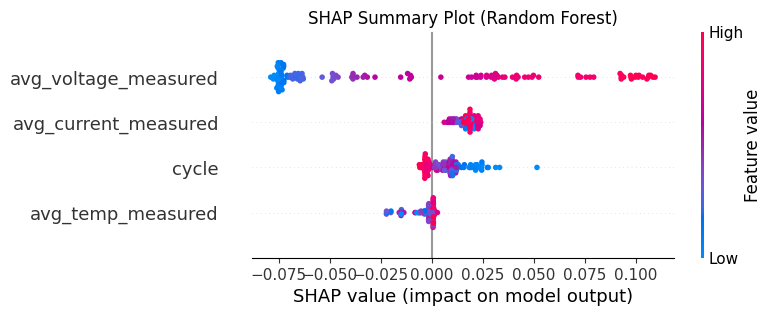

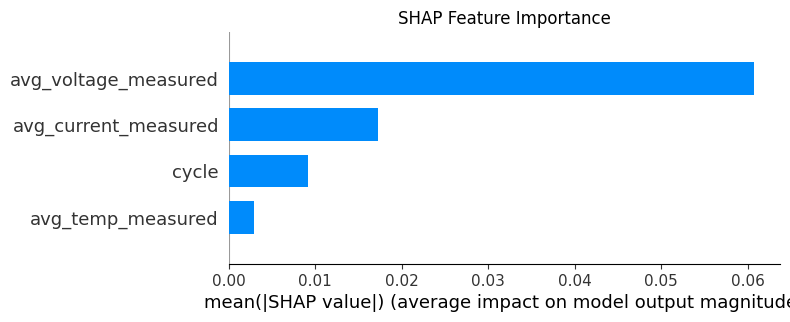

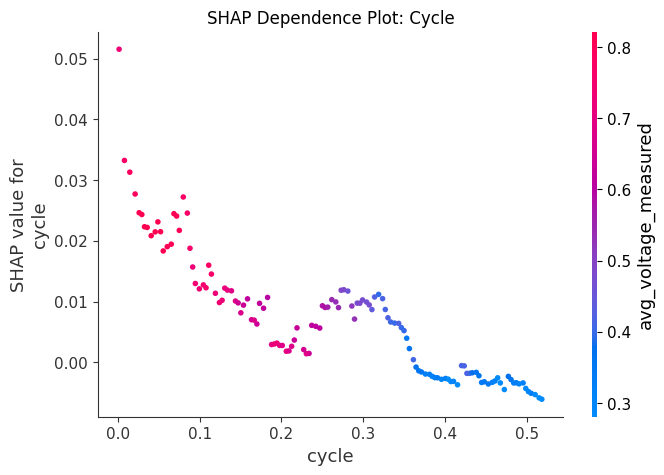

In [187]:
import shap
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

# Initialize JavaScript visualizations (needed for some SHAP plots in notebooks)
shap.initjs()

# --- SHAP Explainability for Random Forest ---
print("\n--- SHAP Explainability (Random Forest) ---")

# 1. Create the Explainer
# TreeExplainer is optimized for Random Forest and XGBoost
explainer = shap.TreeExplainer(rf_model)

# 2. Calculate SHAP values
# We calculate SHAP values for the test set (Battery B0018)
shap_values = explainer.shap_values(X_test_scaled_df)

# 3. Summary Plot (Beeswarm)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled_df, show=False, rng = rng)
plt.title("SHAP Summary Plot (Random Forest)")
plt.show()

# 4. Feature Importance Bar Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", show=False, rng = rng)
plt.title("SHAP Feature Importance")
plt.show()

# 5. Dependence Plot for 'cycle' (Optional but useful)
# Shows the relationship between 'cycle' and its impact on SoH
shap.dependence_plot("cycle", shap_values, X_test_scaled_df, show=False)
plt.title("SHAP Dependence Plot: Cycle")
plt.show()


# Push ML and DL Models to Amazon s3

In [188]:
import os

bucket_name = 's3aravindh973515031797'

# Check existing objects
response = s3.list_objects_v2(Bucket=bucket_name)
for item in response.get("Contents", []):
    print(item["Key"])

Cleaned up VED Source Data/
Cleaned up VED Source Data/df_ICE_HEV.parquet
Cleaned up VED Source Data/df_PHEV_EV.parquet
Cleaned up VED Source Data/df_VED.parquet
Cleaned up VED Source Data/df_combined.parquet
Cleaned up VED Source Data/df_dynamic_sample.parquet
Cleaned up VED Source Data/df_static.parquet
DIYguru ML Source Data/
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171101_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171108_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171115_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171122_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171129_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171206_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171213_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171220_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_171227_week.csv
DIYguru ML Source Data/VED_DynamicData_Part1/VED_180103_week.csv
DIYguru ML Source D

In [189]:
def push_file_to_s3(local_file_path, object_key):
    """
    Pushes a local file (e.g., .joblib, .h5, .keras) to a predefined S3 bucket.

    Args:
        local_file_path (str): The relative or absolute path to the file on your local machine.
        object_key (str): S3 object key (destination path/filename).
    """
    if not os.path.exists(local_file_path):
        print(f"Error: Local file '{local_file_path}' not found.")
        return

    s3.upload_file(local_file_path, bucket_name, object_key)
    print(f"File uploaded to s3://{bucket_name}/{object_key}")

In [190]:
# Example usage for your specific model types:
# push_file_to_s3('model_v1.joblib', 'models/model_v1.joblib')
# push_file_to_s3('my_network.h5', 'models/my_network.h5')
# push_file_to_s3('best_model.keras', 'models/best_model.keras')

# ML_DL_Models/gru_soh_model.h5
# ML_DL_Models/gru_soh_model.keras
# ML_DL_Models/lstm_soh_model.h5
# ML_DL_Models/lstm_soh_model.keras
# ML_DL_Models/rf_soh_model.joblib
# ML_DL_Models/soh_scaler.joblib
# ML_DL_Models/xgb_model.joblib

push_file_to_s3('soh_scaler.joblib', 'ML_DL_Models/soh_scaler.joblib')
push_file_to_s3('rf_soh_model.joblib', 'ML_DL_Models/rf_soh_model.joblib')
push_file_to_s3('xgb_model.joblib', 'ML_DL_Models/xgb_model.joblib')
push_file_to_s3('lstm_soh_model.h5', 'ML_DL_Models/lstm_soh_model.h5')
push_file_to_s3('gru_soh_model.h5', 'ML_DL_Models/gru_soh_model.h5')
push_file_to_s3('lstm_soh_model.keras', 'ML_DL_Models/lstm_soh_model.keras')
push_file_to_s3('gru_soh_model.keras', 'ML_DL_Models/gru_soh_model.keras')

File uploaded to s3://s3aravindh973515031797/ML_DL_Models/soh_scaler.joblib
File uploaded to s3://s3aravindh973515031797/ML_DL_Models/rf_soh_model.joblib
File uploaded to s3://s3aravindh973515031797/ML_DL_Models/xgb_model.joblib
File uploaded to s3://s3aravindh973515031797/ML_DL_Models/lstm_soh_model.h5
File uploaded to s3://s3aravindh973515031797/ML_DL_Models/gru_soh_model.h5
File uploaded to s3://s3aravindh973515031797/ML_DL_Models/lstm_soh_model.keras
File uploaded to s3://s3aravindh973515031797/ML_DL_Models/gru_soh_model.keras


Final Verdict

*   **Feasibility & Goal Achievement:** The project successfully demonstrates the high feasibility of accurately predicting battery SoH. The primary goal of achieving a Mean Absolute Error below ±5% was **exceeded**, with the top models performing under 2% MAE.
*   **Model Recommendation:** While Random Forest is an excellent and interpretable model, the **GRU model is recommended as the overall champion**. Its ability to understand sequential data, combined with its low error and consistent performance, makes it the most robust choice for both SoH estimation and as a foundation for future RUL forecasting.
*   **Critical Features:** The analysis confirms that **cycle number, average discharge voltage, and average temperature** are the most significant predictors of a battery's State of Health.
*   **Future Work:** The trained time-series models (especially GRU) are well-suited for extension into a full RUL forecasting system. Further testing on datasets with complete run-to-failure data would be the logical next step to validate RUL prediction accuracy.